In [1]:
# ============================================================================
# ОБЪЕДИНЕННЫЙ МОДУЛЬНЫЙ КОД ДЛЯ МНОГОМЕТОЧНОЙ КЛАССИФИКАЦИИ
# ============================================================================

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import random
import os
import datetime

2026-01-16 23:11:14.003824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 23:11:15.100167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ============================================================================
# 1. НАСТРОЙКА СИДОВ ДЛЯ ВОСПРОИЗВОДИМОСТИ
# ============================================================================
def set_random_seeds(seed_value=42):
    """Фиксирует все случайные сиды для воспроизводимости"""
    print(f"Установка сида: {seed_value}")
    
    # Python
    random.seed(seed_value)
    
    # NumPy
    np.random.seed(seed_value)
    
    # TensorFlow
    tf.random.set_seed(seed_value)

# Вызываем ДО всего кода
set_random_seeds(42)

Установка сида: 42


In [3]:
# ============================================================================
# 2. КЛАСС ДЛЯ ЗАГРУЗКИ ДАННЫХ
# ============================================================================
class DataLoader:
    @staticmethod
    def load_data():
        base_path = '../Data/Multilabel_CNN_data/'

        X_train_cnn = np.load(f'{base_path}X_train_cnn.npy')
        X_val_cnn = np.load(f'{base_path}X_val_cnn.npy')
        X_test_cnn = np.load(f'{base_path}X_test_cnn.npy')

        y_train = np.load(f'{base_path}y_train.npy')
        y_val = np.load(f'{base_path}y_val.npy')
        y_test = np.load(f'{base_path}y_test.npy')
        
        return X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test

# 2D CNN

In [4]:
# ============================================================================
# 3. КЛАСС ДЛЯ ПОДГОТОВКИ ДАННЫХ
# ============================================================================
class DataPreprocessor2D:
    @staticmethod
    def prepare_for_2d_cnn(X_data):
        """
        Преобразует данные для 2D CNN
        """
        if len(X_data.shape) == 3:
            # Добавляем канальное измерение
            return X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2], 1)
        elif len(X_data.shape) == 4:
            # Данные уже в правильной форме
            return X_data
        else:
            raise ValueError(f"Unexpected input shape: {X_data.shape}")
    
    @staticmethod
    def print_data_shapes(X_train, X_val, X_test):
        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")
    
    @staticmethod
    def analyze_class_distribution(y_train, y_val, y_test, class_names):
        """
        Анализ распределения классов
        """
        print("\n" + "="*50)
        print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ")
        print("="*50)
        
        class_distribution = {}
        for i, name in enumerate(class_names):
            pos_count_train = y_train[:, i].sum()
            pos_count_val = y_val[:, i].sum()
            pos_count_test = y_test[:, i].sum()
            
            class_distribution[name] = {
                'train': {
                    'pos': int(pos_count_train), 
                    'neg': int(len(y_train) - pos_count_train),
                    'percentage': float(pos_count_train/len(y_train)*100)
                },
                'val': {
                    'pos': int(pos_count_val), 
                    'neg': int(len(y_val) - pos_count_val),
                    'percentage': float(pos_count_val/len(y_val)*100)
                },
                'test': {
                    'pos': int(pos_count_test), 
                    'neg': int(len(y_test) - pos_count_test),
                    'percentage': float(pos_count_test/len(y_test)*100)
                }
            }
            
            print(f"{name}:")
            print(f"  Train: {pos_count_train}/{len(y_train)} ({pos_count_train/len(y_train)*100:.1f}%)")
            print(f"  Val:   {pos_count_val}/{len(y_val)} ({pos_count_val/len(y_val)*100:.1f}%)")
            print(f"  Test:  {pos_count_test}/{len(y_test)} ({pos_count_test/len(y_test)*100:.1f}%)")
        
        return class_distribution


# ============================================================================
# 4. КЛАСС ФУНКЦИЙ ПОТЕРЬ И МЕТРИК
# ============================================================================
class F1Score(tf.keras.metrics.Metric):
    """
    Кастомная метрика F1-Score
    """
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


class MacroF1Score(tf.keras.metrics.Metric):
    """
    Macro F1-Score для многометочной классификации
    """
    def __init__(self, num_classes, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.f1_scores = [F1Score(name=f'f1_class_{i}') for i in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
        
        for i in range(self.num_classes):
            self.f1_scores[i].update_state(y_true[:, i], y_pred_binary[:, i], sample_weight)
        
    def result(self):
        f1_values = [f1.result() for f1 in self.f1_scores]
        return tf.reduce_mean(f1_values)
    
    def reset_state(self):
        for f1 in self.f1_scores:
            f1.reset_state()


class LossFactory:
    @staticmethod
    def create_weighted_loss(y_train, class_names=None):
        """
        Создает взвешенную функцию потерь с учетом дисбаланса классов
        """
        num_classes = y_train.shape[1]
        class_weights = {}
        
        print("\nРасчет весов классов:")
        for i in range(num_classes):
            pos_samples = y_train[:, i].sum()
            neg_samples = len(y_train) - pos_samples
            
            weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
            weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
            
            total = weight_for_class_0 + weight_for_class_1
            weight_for_class_0 /= total
            weight_for_class_1 /= total
            
            class_name = class_names[i] if class_names else f"Class_{i}"
            class_weights[i] = {
                'name': class_name,
                0: float(weight_for_class_0), 
                1: float(weight_for_class_1),
                'pos_samples': int(pos_samples),
                'neg_samples': int(neg_samples)
            }
            
            print(f"{class_name}: вес 0={weight_for_class_0:.2f}, вес 1={weight_for_class_1:.2f}, "
                  f"положительных: {pos_samples}, отрицательных: {neg_samples}")
        
        # Функция потерь
        def weighted_binary_crossentropy(y_true, y_pred):
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
            
            losses = []
            for i in range(num_classes):
                # Получаем веса для текущего класса
                w0 = class_weights[i][0]
                w1 = class_weights[i][1]
                
                # Маски для положительных и отрицательных примеров
                y_true_class = y_true[:, i]
                y_pred_class = y_pred[:, i]
                
                # Веса для каждого примера
                weights = y_true_class * w1 + (1 - y_true_class) * w0
                
                # Бинарная кросс-энтропия
                bce = - (y_true_class * tf.math.log(y_pred_class) + 
                        (1 - y_true_class) * tf.math.log(1 - y_pred_class))
                
                # Взвешенная потеря
                weighted_bce = bce * weights
                losses.append(tf.reduce_mean(weighted_bce))
            
            return tf.reduce_mean(losses)
        
        return weighted_binary_crossentropy, class_weights


# ============================================================================
# 5. КЛАСС АРХИТЕКТУР МОДЕЛЕЙ
# ============================================================================
class FeatureExtractor2DFactory:
    @staticmethod
    def create_simple_imbalanced(input_shape, num_features=32):
        """
        Простая архитектура для работы с дисбалансом
        """
        model = models.Sequential(name="2D_CNN_Simple_Imbalanced")
        
        # Первый блок
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                               input_shape=input_shape, name='conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Второй блок
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Третий блок
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Дополнительные dense слои
        model.add(layers.Dense(32, activation='relu', name='dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(5, activation=None, name='dense2'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_standard(input_shape, num_features=32):
        """
        Стандартная 2D CNN архитектура
        """
        model = models.Sequential(name="2D_CNN_Feature_Extractor")
        
        # Блок 1: извлечение низкоуровневых признаков
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                               input_shape=input_shape, name='conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Блок 2: извлечение среднего уровня признаков
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Блок 3: извлечение высокоуровневых признаков
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        
        # Глобальное усреднение
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Слой извлечения признаков
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_deeper(input_shape, num_features=32):
        """Более глубокая 2D CNN архитектура"""
        model = models.Sequential(name="2D_CNN_Deeper_Extractor")
        
        # Блок 1
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                               input_shape=input_shape, name='conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_1b'))
        model.add(layers.BatchNormalization(name='bn1b'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Блок 2
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2b'))
        model.add(layers.BatchNormalization(name='bn2b'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Блок 3
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3b'))
        model.add(layers.BatchNormalization(name='bn3b'))
        
        # Глобальное усреднение
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Слой извлечения признаков
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_with_residual(input_shape, num_features=32):
        """2D CNN с residual connections"""
        inputs = layers.Input(shape=input_shape, name='input')
        
        # Начальный блок
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_1')(inputs)
        x = layers.BatchNormalization(name='bn1')(x)
        x = layers.MaxPooling2D((2, 2), name='pool1')(x)
        
        # Residual блок 1
        residual = x
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2a')(x)
        x = layers.BatchNormalization(name='bn2a')(x)
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2b')(x)
        x = layers.BatchNormalization(name='bn2b')(x)
        
        # Adjust residual dimensions if needed
        if residual.shape[-1] != x.shape[-1]:
            residual = layers.Conv2D(64, (1, 1), padding='same', name='res_conv1')(residual)
            residual = layers.BatchNormalization(name='res_bn1')(residual)
        
        x = layers.Add()([x, residual])
        x = layers.MaxPooling2D((2, 2), name='pool2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        
        # Residual блок 2
        residual = x
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3a')(x)
        x = layers.BatchNormalization(name='bn3a')(x)
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3b')(x)
        x = layers.BatchNormalization(name='bn3b')(x)
        
        # Adjust residual dimensions if needed
        if residual.shape[-1] != x.shape[-1]:
            residual = layers.Conv2D(128, (1, 1), padding='same', name='res_conv2')(residual)
            residual = layers.BatchNormalization(name='res_bn2')(residual)
        
        x = layers.Add()([x, residual])
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dropout(0.4, name='dropout3')(x)
        
        # Слой извлечения признаков
        x = layers.Dense(64, activation='relu', name='feature_dense1')(x)
        features = layers.Dense(num_features, activation=None, name='features')(x)
        
        return Model(inputs=inputs, outputs=features, name="2D_CNN_Residual_Extractor")


# ============================================================================
# 6. КЛАСС ПОЛНОЙ МОДЕЛИ
# ============================================================================
class Model2DFactory:
    @staticmethod
    def create_full_model(input_shape, num_classes, extractor_type='standard', 
                         num_features=32, use_class_weights=True, y_train=None,
                         class_names=None):
        """
        Создает полную 2D CNN модель с учетом дисбаланса
        """
        extractor_factory = FeatureExtractor2DFactory()
        
        if extractor_type == 'standard':
            feature_extractor = extractor_factory.create_standard(input_shape, num_features)
        elif extractor_type == 'simple_imbalanced':
            feature_extractor = extractor_factory.create_simple_imbalanced(input_shape, num_features)
        elif extractor_type == 'deeper':
            feature_extractor = extractor_factory.create_deeper(input_shape, num_features)
        elif extractor_type == 'residual':
            feature_extractor = extractor_factory.create_with_residual(input_shape, num_features)
        else:
            raise ValueError(f"Unknown extractor_type: {extractor_type}")
        
        inputs = layers.Input(shape=input_shape)
        features = feature_extractor(inputs)
        
        # Классификационная головка с учетом дисбаланса
        if use_class_weights and y_train is not None:
            initial_biases = []
            print("\nРасчет начальных смещений для выходного слоя:")
            for i in range(num_classes):
                pos_ratio = y_train[:, i].sum() / len(y_train)
                if pos_ratio > 0 and pos_ratio < 1:
                    initial_bias = np.log(pos_ratio / (1 - pos_ratio))
                else:
                    initial_bias = 0.0
                initial_biases.append(initial_bias)
                
                class_name = class_names[i] if class_names else f"Class_{i}"
                print(f"  {class_name}: pos_ratio={pos_ratio:.4f}, initial_bias={initial_bias:.4f}")
            
            # Классификационные слои
            x = layers.Dense(32, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.4, name='classifier_dropout1')(x)
            x = layers.Dense(5, activation=None, name='classifier_dense2')(x)
            
            # Выходной слой с начальным смещением
            output = layers.Dense(
                num_classes, 
                activation='sigmoid',
                name='output',
                kernel_initializer='glorot_normal',
                bias_initializer=tf.keras.initializers.Constant(initial_biases)
            )(x)
        else:
            # Без учета дисбаланса
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            output = layers.Dense(num_classes, activation='sigmoid', name='output')(x)
        
        full_model = Model(inputs=inputs, outputs=output, 
                          name=f"2D_CNN_{extractor_type.capitalize()}_Imbalanced")
        
        return full_model, feature_extractor


# ============================================================================
# 7. КЛАСС ОПТИМИЗАЦИИ ПОРОГОВ
# ============================================================================
class ThresholdOptimizer:
    @staticmethod
    def find_optimal_thresholds(model, X_val, y_val, class_names):
        """
        Подбор оптимальных порогов для каждого класса
        """
        print("\nПодбор оптимальных порогов:")
        y_pred_proba = model.predict(X_val, verbose=0)
        thresholds = []
        
        for i, name in enumerate(class_names):
            y_true = y_val[:, i]
            y_prob = y_pred_proba[:, i]
            
            best_threshold = 0.5
            best_f1 = 0
            
            # Перебираем пороги от 0.05 до 0.95
            for threshold in np.arange(0.05, 0.95, 0.05):
                y_pred = (y_prob > threshold).astype(int)
                tp = np.sum((y_true == 1) & (y_pred == 1))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                
                if tp + fp > 0 and tp + fn > 0:
                    precision = tp / (tp + fp)
                    recall = tp / (tp + fn)
                    f1 = 2 * precision * recall / (precision + recall)
                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
            
            thresholds.append(best_threshold)
            print(f"{name}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
        
        return thresholds
    
    @staticmethod
    def evaluate_with_thresholds(model, X_test, y_test, class_names, thresholds):
        """
        Оценка модели с оптимальными порогами
        """
        y_pred_proba = model.predict(X_test, verbose=0)
        results_summary = []
        
        print("\nОценка с оптимальными порогами:")
        for i, name in enumerate(class_names):
            threshold = thresholds[i]
            y_true = y_test[:, i]
            y_pred_opt = (y_pred_proba[:, i] > threshold).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred_opt == 1))
            fp = np.sum((y_true == 0) & (y_pred_opt == 1))
            fn = np.sum((y_true == 1) & (y_pred_opt == 0))
            tn = np.sum((y_true == 0) & (y_pred_opt == 0))
            
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            
            results_summary.append({
                'name': name,
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                'pos_count': int(y_true.sum()),
                'neg_count': int(len(y_true) - y_true.sum())
            })
            
            print(f"\n{name} (порог={threshold:.2f}):")
            print(f"  F1-score:  {f1:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Положительных: {y_true.sum()}/{len(y_true)}")
        
        return results_summary, y_pred_proba


# ============================================================================
# 8. КЛАСС ВИЗУАЛИЗАЦИИ ДЛЯ 2D CNN
# ============================================================================
class Visualizer2D:
    @staticmethod
    def visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                         class_names, optimal_thresholds, extractor_type,
                         class_distribution=None, plots_dir=None):
        """
        Визуализация результатов для 2D CNN с сохранением графиков
        """
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Графики обучения
        ax1 = plt.subplot(3, 4, 1)
        ax1.plot(history.history['loss'], label='Train', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Validation', linewidth=2)
        ax1.set_title('Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 4, 2)
        ax2.plot(history.history['macro_f1'], label='Train', linewidth=2)
        ax2.plot(history.history['val_macro_f1'], label='Validation', linewidth=2)
        ax2.set_title('Macro F1-score', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3 = plt.subplot(3, 4, 3)
        if 'auc' in history.history:
            ax3.plot(history.history['auc'], label='Train', linewidth=2)
            ax3.plot(history.history['val_auc'], label='Validation', linewidth=2)
        ax3.set_title('AUC', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 2. F1-score по классам
        ax4 = plt.subplot(3, 4, 4)
        f1_scores = [r['f1'] for r in results_summary]
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        bars = ax4.bar(class_names, f1_scores, color=colors)
        ax4.set_title('F1-score по классам', fontweight='bold')
        ax4.set_ylabel('F1-score')
        ax4.set_ylim(0, 1)
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Precision vs Recall
        ax5 = plt.subplot(3, 4, 5)
        precision_scores = [r['precision'] for r in results_summary]
        recall_scores = [r['recall'] for r in results_summary]
        
        x = np.arange(len(class_names))
        width = 0.35
        ax5.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue', alpha=0.8)
        ax5.bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8)
        ax5.set_title('Precision vs Recall по классам', fontweight='bold')
        ax5.set_xlabel('Класс')
        ax5.set_ylabel('Score')
        ax5.set_xticks(x)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.legend()
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 4. Оптимальные пороги
        ax6 = plt.subplot(3, 4, 6)
        thresholds = [r['threshold'] for r in results_summary]
        bars = ax6.bar(class_names, thresholds, color='lightgreen', alpha=0.7)
        ax6.set_title('Оптимальные пороги по классам', fontweight='bold')
        ax6.set_ylabel('Порог')
        ax6.set_ylim(0, 1)
        for bar, threshold in zip(bars, thresholds):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{threshold:.2f}', ha='center', va='bottom', fontsize=9)
        ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Стандартный порог (0.5)')
        ax6.legend()
        
        # 5. Распределение классов
        ax7 = plt.subplot(3, 4, 7)
        pos_counts = [r['pos_count'] for r in results_summary]
        neg_counts = [r['neg_count'] for r in results_summary]
        
        ax7.bar(class_names, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
        ax7.bar(class_names, pos_counts, bottom=neg_counts, label='Положительные (1)', 
               color='darkred', alpha=0.7)
        ax7.set_title('Распределение классов в тестовой выборке', fontweight='bold')
        ax7.set_xlabel('Класс')
        ax7.set_ylabel('Количество образцов')
        ax7.legend()
        ax7.tick_params(axis='x', rotation=45)
        
        # 6. ROC-кривые
        ax8 = plt.subplot(3, 4, 8)
        ax8.set_title('ROC-кривые по классам', fontweight='bold')
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
        for i, (name, color) in enumerate(zip(class_names, colors)):
            y_true = y_test[:, i]
            y_prob = y_pred_proba_test[:, i]
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax8.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC={roc_auc:.3f})')
        
        ax8.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        ax8.set_xlabel('False Positive Rate')
        ax8.set_ylabel('True Positive Rate')
        ax8.legend(loc='lower right', fontsize=8)
        ax8.grid(True, alpha=0.3)
        
        # 7. Confusion Matrices
        num_matrices = min(4, len(class_names))
        for i, name in enumerate(class_names[:num_matrices]):
            ax = plt.subplot(3, 4, 9 + i)
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > optimal_thresholds[i]).astype(int)
            
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['True 0', 'True 1'],
                       ax=ax, cbar=False)
            ax.set_title(f'Confusion Matrix: {name}', fontweight='bold')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        # 8. Общая статистика
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        avg_precision = np.mean([r['precision'] for r in results_summary])
        avg_recall = np.mean([r['recall'] for r in results_summary])
        macro_f1 = history.history['val_macro_f1'][-1] if 'val_macro_f1' in history.history else avg_f1
        
        stats_text = [
            f'ОБЩАЯ СТАТИСТИКА (2D CNN):',
            f'',
            f'Архитектура: {extractor_type}',
            f'Учет дисбаланса: ДА',
            f'Средний F1-score: {avg_f1:.4f}',
            f'Macro F1-score: {macro_f1:.4f}',
            f'Средний Precision: {avg_precision:.4f}',
            f'Средний Recall: {avg_recall:.4f}',
            f'',
            f'Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]}',
            f'Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]}',
            f'',
            f'Эпох обучения: {len(history.history["loss"])}'
        ]
        
        ax12.text(0.1, 0.9, '\n'.join(stats_text), 
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Результаты 2D CNN модели с учетом дисбаланса ({extractor_type})', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Сохранение основного графика
        if plots_dir:
            main_plot_path = os.path.join(plots_dir, 'main_results.png')
            plt.savefig(main_plot_path, dpi=300, bbox_inches='tight')
            print(f"✓ Основной график сохранен: {main_plot_path}")
        
        plt.show()
        
        # Дополнительные графики
        if len(class_names) > 1:
            correlation_fig = Visualizer2D._plot_correlation_matrices(
                y_test, y_pred_proba_test, class_names, optimal_thresholds
            )
            if plots_dir and correlation_fig:
                correlation_path = os.path.join(plots_dir, 'correlation_matrices.png')
                correlation_fig.savefig(correlation_path, dpi=300, bbox_inches='tight')
                plt.close(correlation_fig)  # Закрываем фигуру после сохранения
                print(f"✓ График корреляций сохранен: {correlation_path}")
        
        # График распределения классов по сетевым
        if class_distribution:
            distribution_fig = Visualizer2D._plot_class_distribution(
                class_distribution, class_names
            )
            if plots_dir and distribution_fig:
                distribution_path = os.path.join(plots_dir, 'class_distribution.png')
                distribution_fig.savefig(distribution_path, dpi=300, bbox_inches='tight')
                plt.close(distribution_fig)  # Закрываем фигуру после сохранения
                print(f"✓ График распределения классов сохранен: {distribution_path}")
        
        # Дополнительные графики обучения
        training_fig = Visualizer2D._plot_training_details(history, plots_dir)
        if training_fig:
            plt.close(training_fig)  # Закрываем фигуру
    
    @staticmethod
    def _plot_correlation_matrices(y_test, y_pred_proba, class_names, optimal_thresholds):
        """Корреляционные матрицы"""
        if len(class_names) < 2:
            return None
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
        y_pred_all = np.zeros_like(y_pred_proba)
        for i, threshold in enumerate(optimal_thresholds):
            y_pred_all[:, i] = (y_pred_proba[:, i] > threshold).astype(int)
        
        pred_corr = np.corrcoef(y_pred_all.T)
        im1 = ax[0].imshow(pred_corr, cmap='coolwarm', vmin=-1, vmax=1)
        ax[0].set_title('Корреляция между предсказаниями классов', fontweight='bold')
        ax[0].set_xticks(range(len(class_names)))
        ax[0].set_yticks(range(len(class_names)))
        ax[0].set_xticklabels(class_names, rotation=45)
        ax[0].set_yticklabels(class_names)
        plt.colorbar(im1, ax=ax[0])
        
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax[0].text(j, i, f'{pred_corr[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontsize=8)
        
        true_corr = np.corrcoef(y_test.T)
        im2 = ax[1].imshow(true_corr, cmap='coolwarm', vmin=-1, vmax=1)
        ax[1].set_title('Корреляция между истинными метками классов', fontweight='bold')
        ax[1].set_xticks(range(len(class_names)))
        ax[1].set_yticks(range(len(class_names)))
        ax[1].set_xticklabels(class_names, rotation=45)
        ax[1].set_yticklabels(class_names)
        plt.colorbar(im2, ax=ax[1])
        
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax[1].text(j, i, f'{true_corr[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontsize=8)
        
        plt.suptitle('Анализ корреляций', fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def _plot_class_distribution(class_distribution, class_names):
        """Распределение классов по сетевым"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Положительные примеры по сетевым
        train_pos = [class_distribution[name]['train']['pos'] for name in class_names]
        val_pos = [class_distribution[name]['val']['pos'] for name in class_names]
        test_pos = [class_distribution[name]['test']['pos'] for name in class_names]
        
        x = np.arange(len(class_names))
        width = 0.25
        
        axes[0].bar(x - width, train_pos, width, label='Train', color='skyblue', alpha=0.8)
        axes[0].bar(x, val_pos, width, label='Validation', color='orange', alpha=0.8)
        axes[0].bar(x + width, test_pos, width, label='Test', color='green', alpha=0.8)
        axes[0].set_title('Положительные примеры по классам', fontweight='bold')
        axes[0].set_xlabel('Класс')
        axes[0].set_ylabel('Количество')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(class_names, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Проценты положительных примеров
        train_percent = [class_distribution[name]['train']['percentage'] for name in class_names]
        val_percent = [class_distribution[name]['val']['percentage'] for name in class_names]
        test_percent = [class_distribution[name]['test']['percentage'] for name in class_names]
        
        axes[1].bar(x - width, train_percent, width, label='Train', color='skyblue', alpha=0.8)
        axes[1].bar(x, val_percent, width, label='Validation', color='orange', alpha=0.8)
        axes[1].bar(x + width, test_percent, width, label='Test', color='green', alpha=0.8)
        axes[1].set_title('Процент положительных примеров', fontweight='bold')
        axes[1].set_xlabel('Класс')
        axes[1].set_ylabel('Процент (%)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(class_names, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Распределение классов в данных', fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def _plot_training_details(history, plots_dir=None):
        """Детальные графики обучения"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # График потерь
        axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Loss during Training', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # График F1-score
        axes[0, 1].plot(history.history['macro_f1'], label='Train Macro F1', linewidth=2)
        axes[0, 1].plot(history.history['val_macro_f1'], label='Validation Macro F1', linewidth=2)
        axes[0, 1].set_title('Macro F1-score during Training', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1-score')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # График accuracy
        if 'accuracy' in history.history:
            axes[1, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
            axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
            axes[1, 0].set_title('Accuracy during Training', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # График LR или валидационного F1
        if 'lr' in history.history:
            axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
            axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Learning Rate')
            axes[1, 1].grid(True, alpha=0.3)
        elif 'val_macro_f1' in history.history:
            axes[1, 1].plot(history.history['val_macro_f1'], linewidth=2, color='green')
            axes[1, 1].set_title('Validation Macro F1', fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('F1-score')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Детали обучения модели', fontweight='bold', fontsize=14)
        plt.tight_layout()
        
        if plots_dir:
            training_details_path = os.path.join(plots_dir, 'training_details.png')
            plt.savefig(training_details_path, dpi=300, bbox_inches='tight')
            print(f"✓ Графики обучения сохранены: {training_details_path}")
        
        plt.show()
        return fig


# ============================================================================
# 9. КЛАСС ТРЕНЕРА И СОХРАНЕНИЯ ДЛЯ 2D CNN
# ============================================================================
class ModelTrainer2D:
    @staticmethod
    def train_model(model, X_train, y_train, X_val, y_val, 
                   epochs=100, batch_size=32, callbacks=None, verbose=0):
        """Обучение модели"""
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        return history


class ModelSaver2D:
    @staticmethod
    def setup_save_directory(base_dir='../Debugging_Information/Fin_exp_models', 
                           extractor_type='standard'):
        """
        Настройка директории сохранения
        """
        # Создаем поддиректорию с учетом типа архитектуры
        model_save_dir = os.path.join(base_dir, f'2D_CNN_{extractor_type}')
        os.makedirs(model_save_dir, exist_ok=True)
        
        # Поддиректории для графиков
        plots_dir = os.path.join(model_save_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        
        # Поддиректории для моделей
        models_dir = os.path.join(model_save_dir, 'models')
        os.makedirs(models_dir, exist_ok=True)
        
        print(f"Директория сохранения: {model_save_dir}")
        return model_save_dir, plots_dir, models_dir
    
    @staticmethod
    def save_results(model_save_dir, results_summary, history, class_distribution,
                    optimal_thresholds, y_pred_proba, y_test, model, feature_extractor,
                    extractor_type, class_names, plots_dir=None):
        """
        Сохранение всех результатов
        """
        print(f"\nСохранение результатов в {model_save_dir}...")
        
        # 1. Сохранение модели
        model_path = os.path.join(model_save_dir, 'models', 'best_model.keras')
        model.save(model_path)
        print(f"✓ Модель сохранена: {model_path}")
        
        # 2. Сохранение истории обучения
        np.save(os.path.join(model_save_dir, 'training_history.npy'), history.history)
        
        # 3. Сохранение распределения классов
        np.save(os.path.join(model_save_dir, 'class_distribution.npy'), class_distribution)
        
        # 4. Сохранение оптимальных порогов
        np.save(os.path.join(model_save_dir, 'optimal_thresholds.npy'), optimal_thresholds)
        
        # 5. Сохранение результатов
        np.save(os.path.join(model_save_dir, 'results_summary.npy'), results_summary)
        
        # 6. Сохранение предсказаний
        np.save(os.path.join(model_save_dir, 'predictions.npy'), {
            'y_pred_proba': y_pred_proba,
            'y_pred': (y_pred_proba > 0.5).astype(int),
            'y_test': y_test
        })
        
        # 7. Сохранение текстовой сводки
        ModelSaver2D._save_experiment_summary(model_save_dir, results_summary, history,
                                          extractor_type, class_names, optimal_thresholds)
        
        # 8. Сохранение весов классов
        ModelSaver2D._save_class_weights(model_save_dir, results_summary, class_names)
        
        # 9. Сохранение метрик обучения в CSV (если есть pandas)
        try:
            import pandas as pd
            ModelSaver2D._save_training_metrics_csv(model_save_dir, history)
        except ImportError:
            print("⚠ Pandas не установлен, пропускаем сохранение CSV")
        
        print(f"✓ Все результаты сохранены в {model_save_dir}")
    
    @staticmethod
    def _save_experiment_summary(model_save_dir, results_summary, history,
                               extractor_type, class_names, thresholds):
        """Сохранение текстовой сводки эксперимента"""
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        best_val_f1 = max(history.history['val_macro_f1'])
        best_epoch = np.argmax(history.history['val_macro_f1']) + 1
        
        summary_text = f"""
РЕЗУЛЬТАТЫ МНОГОМЕТОЧНОЙ КЛАССИФИКАЦИИ С УЧЕТОМ ДИСБАЛАНСА
============================================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Архитектура: 2D CNN ({extractor_type})
Классы: {', '.join(class_names)}

ОБУЧЕНИЕ:
---------
Лучшая эпоха: {best_epoch}
Лучший val Macro F1-score: {best_val_f1:.4f}
Эпох обучения: {len(history.history['loss'])}

ОБЩИЕ РЕЗУЛЬТАТЫ:
-----------------
Средний F1-score: {avg_f1:.4f}
Оптимальные пороги: {', '.join(f'{t:.2f}' for t in thresholds)}

МЕТРИКИ ПО КЛАССАМ:
------------------
{chr(10).join(f'{r["name"]}: F1={r["f1"]:.4f}, Prec={r["precision"]:.4f}, Rec={r["recall"]:.4f}, Порог={r["threshold"]:.2f}' for r in results_summary)}

РЕКОМЕНДАЦИИ:
------------
Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]} (F1={max([r["f1"] for r in results_summary]):.4f})
Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]} (F1={min([r["f1"] for r in results_summary]):.4f})
"""
        
        summary_path = os.path.join(model_save_dir, 'experiment_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary_text)
    
    @staticmethod
    def _save_class_weights(model_save_dir, results_summary, class_names):
        """Сохранение информации о весах классов"""
        weights_info = {}
        for r in results_summary:
            weights_info[r['name']] = {
                'pos_count': r['pos_count'],
                'neg_count': r['neg_count'],
                'imbalance_ratio': r['pos_count'] / (r['neg_count'] + 1e-7)
            }
        
        np.save(os.path.join(model_save_dir, 'class_weights_info.npy'), weights_info)
    
    @staticmethod
    def _save_training_metrics_csv(model_save_dir, history):
        """Сохранение метрик обучения в CSV"""
        try:
            import pandas as pd
            df_metrics = pd.DataFrame(history.history)
            csv_path = os.path.join(model_save_dir, 'training_metrics.csv')
            df_metrics.to_csv(csv_path, index_label='epoch')
            print(f"✓ Метрики обучения сохранены в CSV: {csv_path}")
        except ImportError:
            print("⚠ Pandas не установлен, пропускаем сохранение CSV")


# ============================================================================
# 10. ОСНОВНОЙ СКРИПТ ДЛЯ ЗАПУСКА
# ============================================================================
def run_combined_2d_cnn_experiment(extractor_type='simple_imbalanced', epochs=100):
    """
    Основная функция для запуска эксперимента 2D CNN
    """
    print("\n" + "="*60)
    print(f"МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ 2D CNN ({extractor_type.upper()})")
    print("С УЧЕТОМ ДИСБАЛАНСА КЛАССОВ")
    print("="*60)
    
    # 0. Загрузка данных
    print("\n0. Загрузка данных...")
    data_loader = DataLoader()
    X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()
    
    # Конфигурация
    INPUT_SHAPE = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
    NUM_CLASSES = y_train.shape[1]
    CLASS_NAMES = ['hu', 'hg', 'hs', 'hm', 'hi']
    
    # 1. Подготовка данных
    print("\n1. Подготовка данных...")
    preprocessor = DataPreprocessor2D()
    X_train_2d = preprocessor.prepare_for_2d_cnn(X_train_cnn)
    X_val_2d = preprocessor.prepare_for_2d_cnn(X_val_cnn)
    X_test_2d = preprocessor.prepare_for_2d_cnn(X_test_cnn)
    
    preprocessor.print_data_shapes(X_train_2d, X_val_2d, X_test_2d)
    
    # 2. Анализ распределения классов
    class_distribution = preprocessor.analyze_class_distribution(
        y_train, y_val, y_test, CLASS_NAMES
    )
    
    # 3. Создание функции потерь с учетом дисбаланса
    print("\n2. Создание функции потерь с учетом дисбаланса...")
    loss_factory = LossFactory()
    weighted_loss_func, class_weights_info = loss_factory.create_weighted_loss(
        y_train, CLASS_NAMES
    )
    
    # 4. Создание модели
    print(f"\n3. Создание 2D CNN модели ({extractor_type})...")
    model_factory = Model2DFactory()
    model, feature_extractor = model_factory.create_full_model(
        INPUT_SHAPE, 
        NUM_CLASSES, 
        extractor_type=extractor_type,
        num_features=20,
        use_class_weights=True,
        y_train=y_train,
        class_names=CLASS_NAMES
    )
    
    # 5. Компиляция модели
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss=weighted_loss_func,
        metrics=[
            'accuracy',
            F1Score(threshold=0.5, name='f1_score'),
            MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
            tf.keras.metrics.AUC(multi_label=True, name='auc'),
            tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
            tf.keras.metrics.Recall(thresholds=0.5, name='recall')
        ]
    )
    
    model.summary()
    
    # 6. Настройка директории сохранения
    print("\n4. Настройка сохранения...")
    saver = ModelSaver2D()
    model_save_dir, plots_dir, models_dir = saver.setup_save_directory(
        base_dir='../Debugging_Information/Fin_exp_models',
        extractor_type=extractor_type
    )
    
    # 7. Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_macro_f1',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_macro_f1',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
            mode='max'
        ),
        ModelCheckpoint(
            os.path.join(models_dir, 'best_model_epoch_{epoch:02d}.keras'),
            monitor='val_macro_f1',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    # 8. Обучение модели
    print(f"\n5. Обучение модели ({epochs} эпох)...")
    trainer = ModelTrainer2D()
    history = trainer.train_model(
        model=model,
        X_train=X_train_2d,
        y_train=y_train,
        X_val=X_val_2d,
        y_val=y_val,
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # 9. Подбор оптимальных порогов
    print("\n6. Подбор оптимальных порогов...")
    threshold_optimizer = ThresholdOptimizer()
    optimal_thresholds = threshold_optimizer.find_optimal_thresholds(
        model, X_val_2d, y_val, CLASS_NAMES
    )
    
    # 10. Оценка на тестовых данных
    print("\n7. Оценка на тестовых данных...")
    results_summary, y_pred_proba_test = threshold_optimizer.evaluate_with_thresholds(
        model, X_test_2d, y_test, CLASS_NAMES, optimal_thresholds
    )
    
    # 11. Визуализация результатов
    print("\n8. Визуализация результатов...")
    visualizer = Visualizer2D()
    visualizer.visualize_results(
        history, results_summary, y_test, y_pred_proba_test,
        CLASS_NAMES, optimal_thresholds, extractor_type, 
        class_distribution, plots_dir  # Передаем plots_dir
    )
    
    # 12. Сохранение всех результатов
    saver.save_results(
        model_save_dir, results_summary, history, class_distribution,
        optimal_thresholds, y_pred_proba_test, y_test, model, feature_extractor,
        extractor_type, CLASS_NAMES, plots_dir  # Передаем plots_dir
    )
    
    # 13. Финальная сводка
    print("\n" + "="*60)
    print("ФИНАЛЬНАЯ СВОДКА")
    print("="*60)
    
    avg_f1 = np.mean([r['f1'] for r in results_summary])
    best_val_f1 = max(history.history['val_macro_f1'])
    best_epoch = np.argmax(history.history['val_macro_f1']) + 1
    
    print(f"\nАрхитектура: {extractor_type}")
    print(f"Средний F1-score: {avg_f1:.4f}")
    print(f"Лучший val Macro F1: {best_val_f1:.4f} (эпоха {best_epoch})")
    print(f"Оптимальные пороги: {', '.join(f'{t:.2f}' for t in optimal_thresholds)}")
    
    # Список сохраненных файлов
    print(f"\nСОХРАНЕННЫЕ ФАЙЛЫ:")
    print(f"  Модель: {os.path.join(models_dir, 'best_model.keras')}")
    print(f"  Основной график: {os.path.join(plots_dir, 'main_results.png')}")
    print(f"  Графики обучения: {os.path.join(plots_dir, 'training_details.png')}")
    print(f"  Корреляционные матрицы: {os.path.join(plots_dir, 'correlation_matrices.png')}")
    print(f"  Распределение классов: {os.path.join(plots_dir, 'class_distribution.png')}")
    print(f"  Текстовая сводка: {os.path.join(model_save_dir, 'experiment_summary.txt')}")
    print(f"  Метрики обучения: {os.path.join(model_save_dir, 'training_metrics.csv')}")
    
    return model, history, results_summary


def run_all_experiments():
    """
    Запуск экспериментов с разными архитектурами
    """
    architectures = ['simple_imbalanced', 'standard', 'deeper', 'residual']
    
    results = {}
    for arch in architectures:
        print(f"\n{'#'*80}")
        print(f"ЭКСПЕРИМЕНТ С АРХИТЕКТУРОЙ: {arch.upper()}")
        print(f"{'#'*80}")
        
        try:
            model, history, results_summary = run_combined_2d_cnn_experiment(
                extractor_type=arch,
                epochs=100
            )
            
            results[arch] = {
                'model': model,
                'history': history,
                'results_summary': results_summary,
                'avg_f1': np.mean([r['f1'] for r in results_summary])
            }
            
        except Exception as e:
            print(f"Ошибка при обучении архитектуры {arch}: {e}")
            continue
    
    # Сравнение результатов
    print(f"\n{'#'*80}")
    print("СРАВНЕНИЕ АРХИТЕКТУР")
    print(f"{'#'*80}")
    
    for arch, res in results.items():
        print(f"{arch.upper():<20} Средний F1: {res['avg_f1']:.4f}")
    
    return results

НАЧАЛО ЭКСПЕРИМЕНТОВ

МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ 2D CNN (DEEPER)
С УЧЕТОМ ДИСБАЛАНСА КЛАССОВ

0. Загрузка данных...

1. Подготовка данных...
X_train shape: (999, 25, 16, 1)
X_val shape: (429, 25, 16, 1)
X_test shape: (612, 25, 16, 1)

АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ
hu:
  Train: 22.0/999 (2.2%)
  Val:   9.0/429 (2.1%)
  Test:  14.0/612 (2.3%)
hg:
  Train: 8.0/999 (0.8%)
  Val:   3.0/429 (0.7%)
  Test:  4.0/612 (0.7%)
hs:
  Train: 44.0/999 (4.4%)
  Val:   19.0/429 (4.4%)
  Test:  27.0/612 (4.4%)
hm:
  Train: 29.0/999 (2.9%)
  Val:   13.0/429 (3.0%)
  Test:  18.0/612 (2.9%)
hi:
  Train: 169.0/999 (16.9%)
  Val:   72.0/429 (16.8%)
  Test:  104.0/612 (17.0%)

2. Создание функции потерь с учетом дисбаланса...

Расчет весов классов:
hu: вес 0=0.02, вес 1=0.98, положительных: 22.0, отрицательных: 977.0
hg: вес 0=0.01, вес 1=0.99, положительных: 8.0, отрицательных: 991.0
hs: вес 0=0.04, вес 1=0.96, положительных: 44.0, отрицательных: 955.0
hm: вес 0=0.03, вес 1=0.97, положительных: 29.0, отрицат

/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-16 23:11:17.675467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-16 23:11:17.947839: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices.

Model: "2D_CNN_Deeper_Imbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2D_CNN_Deeper_Extractor         │ (None, 20)             │       297,780 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,647 (1.14 MB)

 Trainable params: 297,751 (1.14 MB)

 Non-trainable params: 896 (3.50 KB)


4. Настройка сохранения...
Директория сохранения: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper

5. Обучение модели (100 эпох)...
Epoch 1/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1250 - auc: 0.4910 - f1_score: 0.1955 - loss: 0.1170 - macro_f1: 0.0771 - precision: 0.2568 - recall: 0.2278
Epoch 1: val_macro_f1 improved from None to 0.00000, saving model to ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/models/best_model_epoch_01.keras

Epoch 1: finished saving model to ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/models/best_model_epoch_01.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.1301 - auc: 0.5651 - f1_score: 0.2531 - loss: 0.0975 - macro_f1: 0.1071 - precision: 0.1920 - recall: 0.3713 - val_accuracy: 0.1445 - val_auc: 0.5864 - val_f1_score: 0.0000e+00 - val_loss: 0.1022 - val_macro_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step -

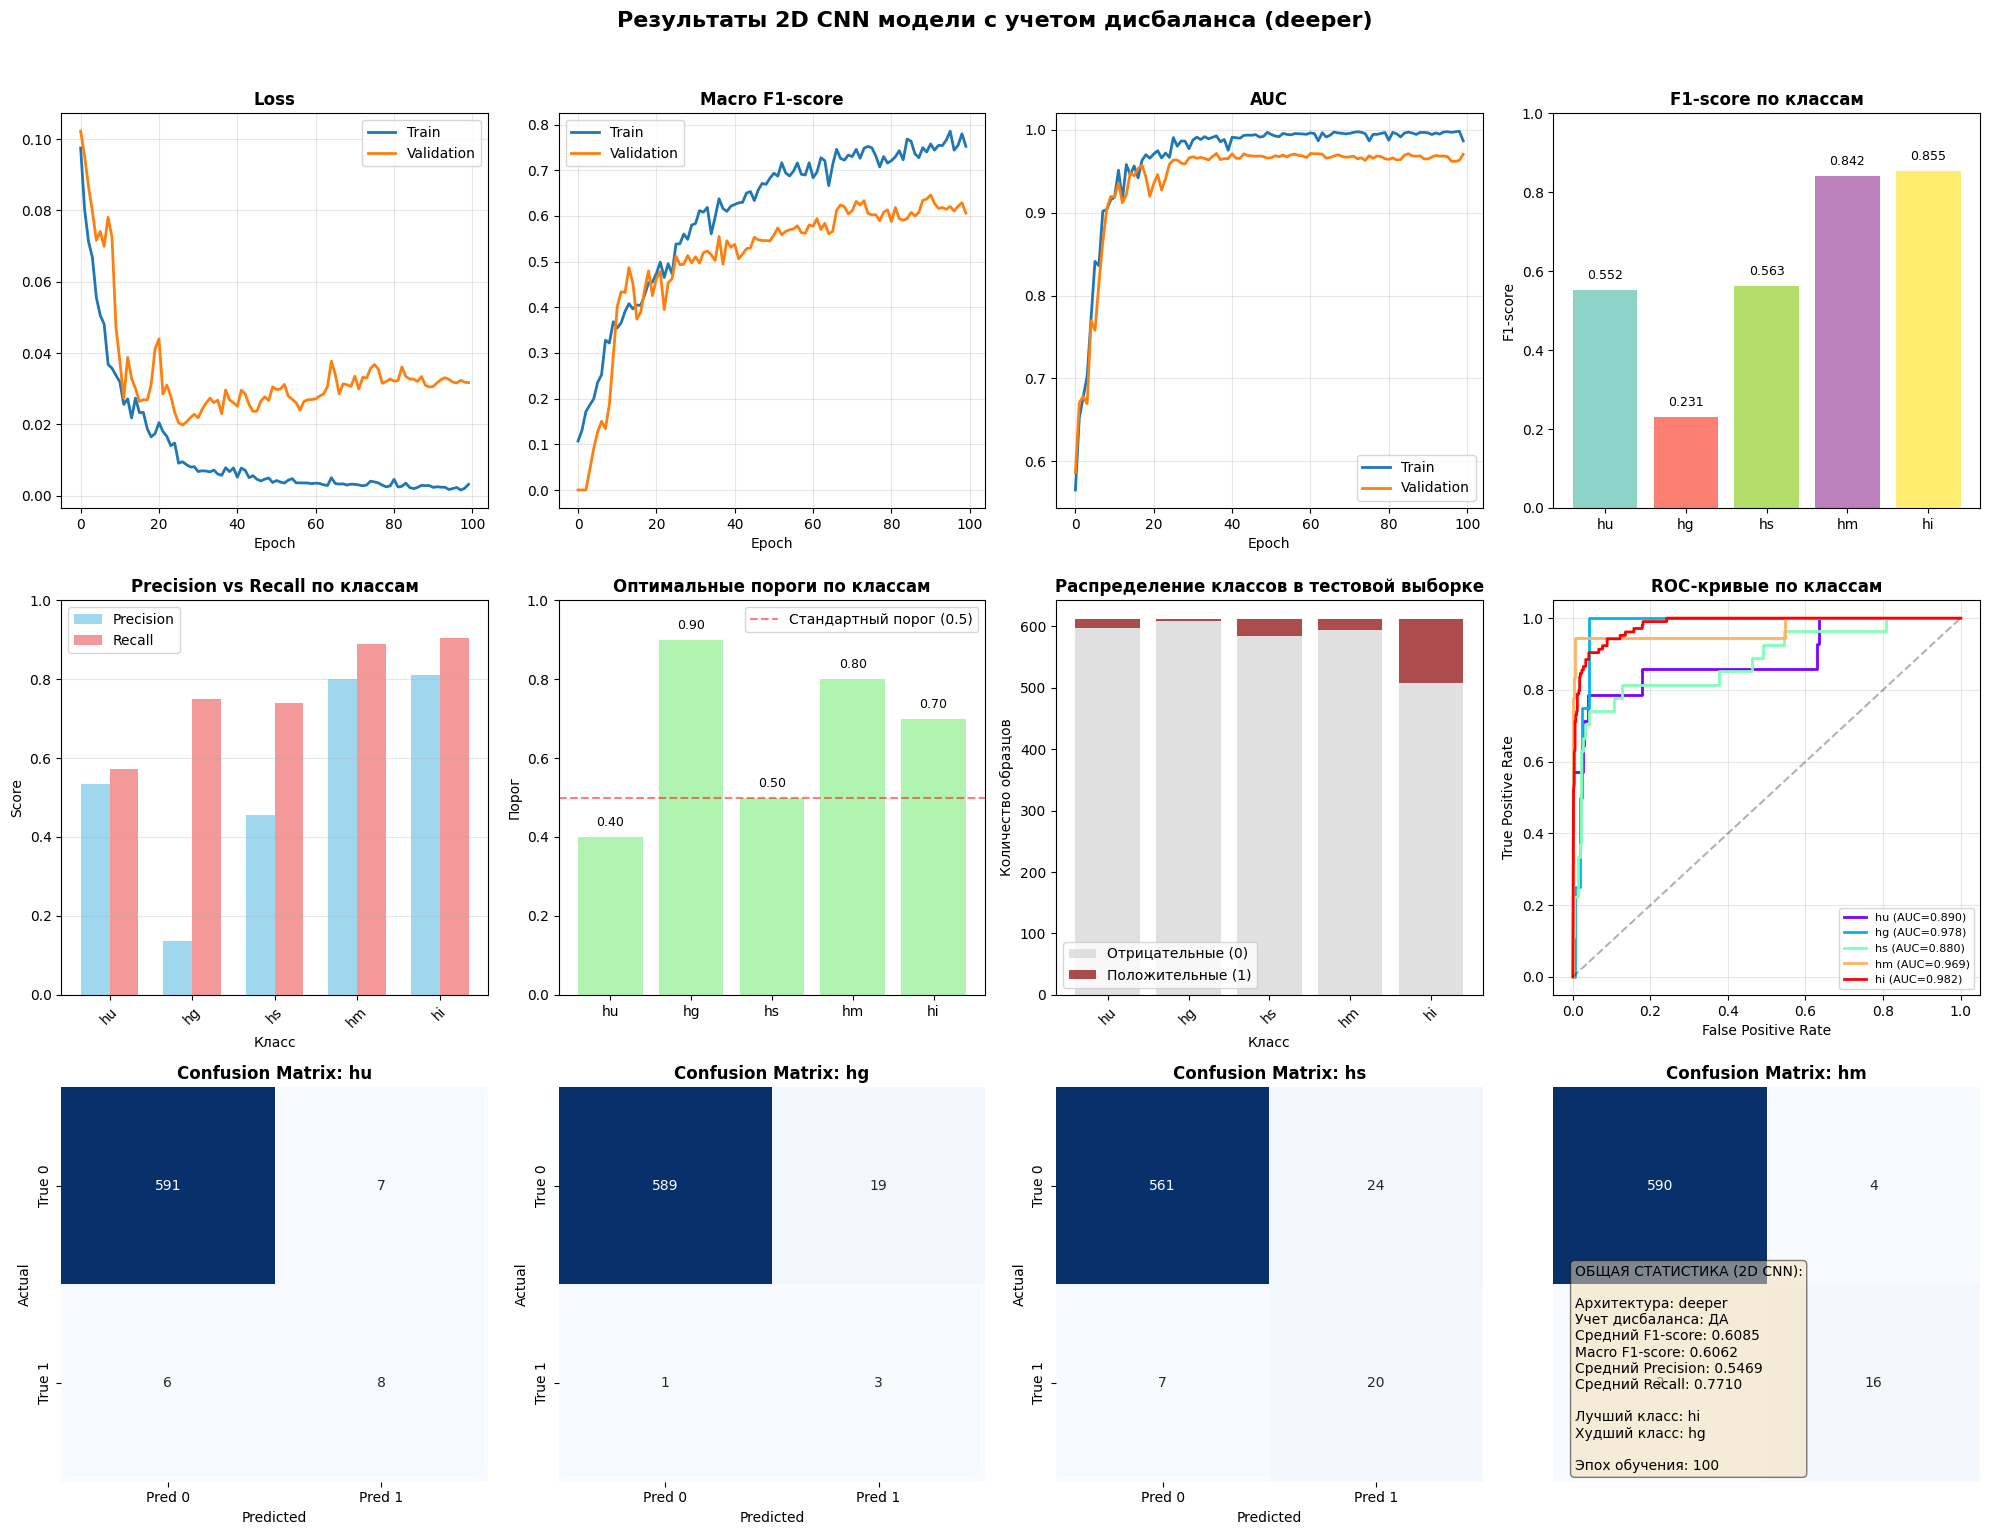

✓ График корреляций сохранен: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/correlation_matrices.png
✓ График распределения классов сохранен: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/class_distribution.png
✓ Графики обучения сохранены: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/training_details.png


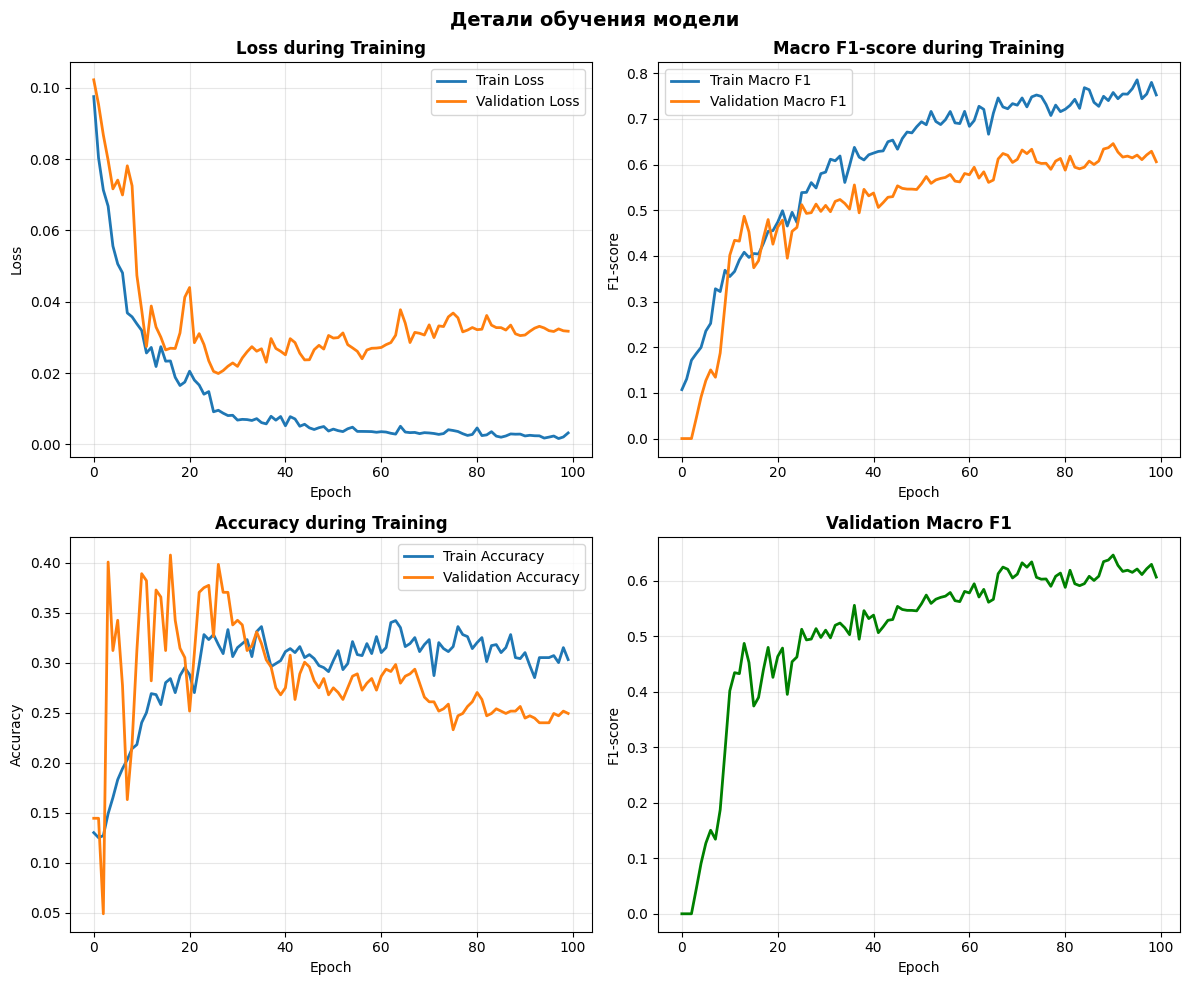


Сохранение результатов в ../Debugging_Information/Fin_exp_models/2D_CNN_deeper...
✓ Модель сохранена: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/models/best_model.keras
✓ Метрики обучения сохранены в CSV: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/training_metrics.csv
✓ Все результаты сохранены в ../Debugging_Information/Fin_exp_models/2D_CNN_deeper

ФИНАЛЬНАЯ СВОДКА

Архитектура: deeper
Средний F1-score: 0.6085
Лучший val Macro F1: 0.6459 (эпоха 91)
Оптимальные пороги: 0.40, 0.90, 0.50, 0.80, 0.70

СОХРАНЕННЫЕ ФАЙЛЫ:
  Модель: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/models/best_model.keras
  Основной график: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/main_results.png
  Графики обучения: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/training_details.png
  Корреляционные матрицы: ../Debugging_Information/Fin_exp_models/2D_CNN_deeper/plots/correlation_matrices.png
  Распределение классов: ../Debugging_Information/Fin_exp

In [5]:
# ============================================================================
# ЗАПУСК ЭКСПЕРИМЕНТА
# ============================================================================

# Запуск одного эксперимента
print("НАЧАЛО ЭКСПЕРИМЕНТОВ")
print("="*80)

model, history, results = run_combined_2d_cnn_experiment(
    extractor_type='deeper',  # или 'standard', 'deeper', 'residual', 'simple_imbalanced'
    epochs=100
)

# Просмотр структуры модели

In [6]:
model.summary()

data_loader = DataLoader()
X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()


# Создаем feature_extractor заново, чтобы иметь к нему доступ
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
extractor_type = 'deeper'  # или другая архитектура

extractor_factory = FeatureExtractor2DFactory()

if extractor_type == 'standard':
    feature_extractor = extractor_factory.create_standard(input_shape, num_features=20)
elif extractor_type == 'simple_imbalanced':
    feature_extractor = extractor_factory.create_simple_imbalanced(input_shape, num_features=20)
elif extractor_type == 'deeper':
    feature_extractor = extractor_factory.create_deeper(input_shape, num_features=20)
elif extractor_type == 'residual':
    feature_extractor = extractor_factory.create_with_residual(input_shape, num_features=20)

# Выводим структуру feature_extractor
print("\n1. Сводка feature_extractor:")
feature_extractor.summary()

# Создаем классификационную головку с учетом дисбаланса
num_classes = 5
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

# Расчет начальных смещений для выходного слоя
print("\nРасчет начальных смещений:")
initial_biases = []
for i in range(num_classes):
    pos_ratio = y_train[:, i].sum() / len(y_train)
    if pos_ratio > 0 and pos_ratio < 1:
        initial_bias = np.log(pos_ratio / (1 - pos_ratio))
    else:
        initial_bias = 0.0
    initial_biases.append(initial_bias)
    
    print(f"  {class_names[i]}: pos_ratio={pos_ratio:.4f}, initial_bias={initial_bias:.4f}")

# Создаем классификационную головку
print("\nСлои классификационной головки:")

# Входной слой для признаков (размерность = num_features из feature_extractor)
num_features = 20  # Должен совпадать с output_dim feature_extractor
features_input = layers.Input(shape=(num_features,), name='features_input')

# Слой 1
x = layers.Dense(32, activation='relu', name='classifier_dense1')(features_input)
print(f"1. Dense(32, relu)      -> output shape: {x.shape}")

# Dropout
x = layers.Dropout(0.4, name='classifier_dropout1')(x)
print(f"2. Dropout(0.4)         -> output shape: {x.shape}")

# Слой 2
x = layers.Dense(5, activation=None, name='classifier_dense2')(x)
print(f"3. Dense(5, linear)     -> output shape: {x.shape}")

# Выходной слой с начальным смещением
output = layers.Dense(
    num_classes, 
    activation='sigmoid',
    name='classifier_output',
    kernel_initializer='glorot_normal',
    bias_initializer=tf.keras.initializers.Constant(initial_biases)
)(x)
print(f"4. Dense({num_classes}, sigmoid) -> output shape: {output.shape}")

# Создаем модель классификационной головки
classifier_head = Model(inputs=features_input, outputs=output, name='Classifier_Head')

print("\n" + "-" * 80)
print("Сводка классификационной головки:")
classifier_head.summary()

Model: "2D_CNN_Deeper_Imbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2D_CNN_Deeper_Extractor         │ (None, 20)             │       297,780 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,151 (3.41 MB)

 Trainable params: 297,751 (1.14 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 595,504 (2.27 MB)


1. Сводка feature_extractor:


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "2D_CNN_Deeper_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 25, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1b (Conv2D)              │ (None, 25, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1b (BatchNormalization)       │ (None, 25, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2b (Conv2D)              │ (None, 12, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2b (BatchNormalization)       │ (None, 12, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3b (Conv2D)              │ (None, 6, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3b (BatchNormalization)       │ (None, 6, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,780 (1.14 MB)

 Trainable params: 296,884 (1.13 MB)

 Non-trainable params: 896 (3.50 KB)


Расчет начальных смещений:
  hu: pos_ratio=0.0220, initial_bias=-3.7934
  hg: pos_ratio=0.0080, initial_bias=-4.8193
  hs: pos_ratio=0.0440, initial_bias=-3.0775
  hm: pos_ratio=0.0290, initial_bias=-3.5100
  hi: pos_ratio=0.1692, initial_bias=-1.5915

Слои классификационной головки:
1. Dense(32, relu)      -> output shape: (None, 32)
2. Dropout(0.4)         -> output shape: (None, 32)
3. Dense(5, linear)     -> output shape: (None, 5)
4. Dense(5, sigmoid) -> output shape: (None, 5)

--------------------------------------------------------------------------------
Сводка классификационной головки:


Model: "Classifier_Head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features_input (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 867 (3.39 KB)

 Trainable params: 867 (3.39 KB)

 Non-trainable params: 0 (0.00 B)

# 1D CNN

In [7]:
# ============================================================================
# 3. КЛАСС ДЛЯ ПОДГОТОВКИ ДАННЫХ ДЛЯ 1D CNN
# ============================================================================
class DataPreprocessor1D:
    @staticmethod
    def prepare_for_1d_cnn(X_data):
        """
        Преобразует данные для 1D CNN
        """
        if len(X_data.shape) == 4 and X_data.shape[3] == 1:
            # Убираем канальное измерение
            return X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2])
        elif len(X_data.shape) == 3:
            # Данные уже в правильной форме (samples, timesteps, features)
            return X_data
        else:
            raise ValueError(f"Unexpected input shape: {X_data.shape}")
    
    @staticmethod
    def print_data_shapes(X_train, X_val, X_test):
        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")
    
    @staticmethod
    def analyze_class_distribution(y_train, y_val, y_test, class_names):
        """
        Анализ распределения классов
        """
        print("\n" + "="*50)
        print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ")
        print("="*50)
        
        class_distribution = {}
        for i, name in enumerate(class_names):
            pos_count_train = y_train[:, i].sum()
            pos_count_val = y_val[:, i].sum()
            pos_count_test = y_test[:, i].sum()
            
            class_distribution[name] = {
                'train': {
                    'pos': int(pos_count_train), 
                    'neg': int(len(y_train) - pos_count_train),
                    'percentage': float(pos_count_train/len(y_train)*100)
                },
                'val': {
                    'pos': int(pos_count_val), 
                    'neg': int(len(y_val) - pos_count_val),
                    'percentage': float(pos_count_val/len(y_val)*100)
                },
                'test': {
                    'pos': int(pos_count_test), 
                    'neg': int(len(y_test) - pos_count_test),
                    'percentage': float(pos_count_test/len(y_test)*100)
                }
            }
            
            print(f"{name}:")
            print(f"  Train: {pos_count_train}/{len(y_train)} ({pos_count_train/len(y_train)*100:.1f}%)")
            print(f"  Val:   {pos_count_val}/{len(y_val)} ({pos_count_val/len(y_val)*100:.1f}%)")
            print(f"  Test:  {pos_count_test}/{len(y_test)} ({pos_count_test/len(y_test)*100:.1f}%)")
        
        return class_distribution

# ============================================================================
# 4. КЛАСС ФУНКЦИЙ ПОТЕРЬ И МЕТРИК
# ============================================================================
class F1Score(tf.keras.metrics.Metric):
    """
    Кастомная метрика F1-Score для 1D CNN
    """
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        denominator = precision + recall + tf.keras.backend.epsilon()
        return 2 * ((precision * recall) / denominator)
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


class MacroF1Score(tf.keras.metrics.Metric):
    """
    Macro F1-Score для многометочной классификации
    """
    def __init__(self, num_classes, name='macro_f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.f1_scores = [F1Score(threshold=threshold, name=f'f1_class_{i}') 
                         for i in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.f1_scores[i].update_state(y_true[:, i:i+1], y_pred[:, i:i+1], sample_weight)
        
    def result(self):
        f1_values = [f1_score.result() for f1_score in self.f1_scores]
        return tf.reduce_mean(f1_values)
    
    def reset_state(self):
        for f1_score in self.f1_scores:
            f1_score.reset_state()


class LossFactory:
    @staticmethod
    def create_weighted_loss(y_train, class_names):
        """
        Создает взвешенную функцию потерь с учетом дисбаланса классов
        """
        class_weights_info = []
        
        for i in range(len(class_names)):
            pos_samples = y_train[:, i].sum()
            neg_samples = len(y_train) - pos_samples
            
            weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
            weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
            
            total = weight_for_class_0 + weight_for_class_1
            weight_for_class_0 /= total
            weight_for_class_1 /= total
            
            class_weights_info.append({
                'name': class_names[i],
                'weight_0': float(weight_for_class_0),
                'weight_1': float(weight_for_class_1),
                'pos_samples': int(pos_samples),
                'neg_samples': int(neg_samples)
            })
            
            print(f"{class_names[i]}: вес класса 0={weight_for_class_0:.2f}, "
                  f"вес класса 1={weight_for_class_1:.2f}, "
                  f"положительных={pos_samples}")
        
        def weighted_binary_crossentropy_v2(y_true, y_pred):
            loss = 0
            for i, weights_dict in enumerate(class_weights_info):
                # Для каждого класса отдельно
                y_true_i = y_true[:, i]
                y_pred_i = y_pred[:, i]
                
                # Веса для текущего класса
                weights_i = tf.where(
                    y_true_i > 0.5,
                    weights_dict['weight_1'],
                    weights_dict['weight_0']
                )
                
                # Кросс-энтропия для текущего класса
                bce_i = tf.keras.losses.binary_crossentropy(
                    tf.expand_dims(y_true_i, axis=-1),
                    tf.expand_dims(y_pred_i, axis=-1)
                )
                
                # Взвешенная потеря
                loss += tf.reduce_mean(bce_i * weights_i)
            
            return loss / len(class_weights_info)
        
        return weighted_binary_crossentropy_v2, class_weights_info

# ============================================================================
# 5. КЛАСС АРХИТЕКТУР МОДЕЛЕЙ 1D CNN
# ============================================================================
class FeatureExtractor1DFactory:
    @staticmethod
    def create_standard(input_shape, num_features=32):
        """
        Стандартная 1D CNN архитектура
        """
        model = models.Sequential(name="1D_CNN_Feature_Extractor")
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', 
                               input_shape=input_shape, name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_by_features(input_shape, num_features=32):
        """
        1D CNN с обработкой по признакам
        """
        model = models.Sequential(name="1D_CNN_By_Features_Extractor")
        model.add(layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1]), 
                               input_shape=input_shape, 
                               name='transpose'))
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_bidirectional(input_shape, num_features=32):
        """
        Двунаправленная 1D CNN архитектура
        """
        inputs = layers.Input(shape=input_shape, name='input')
        
        x = layers.Bidirectional(
            layers.Conv1D(32, 3, padding='same', activation='relu'), 
            name='bidirectional_conv1'
        )(inputs)
        x = layers.BatchNormalization(name='bn1')(x)
        x = layers.MaxPooling1D(2, name='pool1')(x)
        x = layers.Dropout(0.2, name='dropout1')(x)
        
        x = layers.Bidirectional(
            layers.Conv1D(64, 3, padding='same', activation='relu'), 
            name='bidirectional_conv2'
        )(x)
        x = layers.BatchNormalization(name='bn2')(x)
        x = layers.MaxPooling1D(2, name='pool2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        
        x = layers.Bidirectional(
            layers.Conv1D(128, 3, padding='same', activation='relu'), 
            name='bidirectional_conv3'
        )(x)
        x = layers.BatchNormalization(name='bn3')(x)
        x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
        
        x = layers.Dense(32, activation='relu', name='feature_dense1')(x)
        x = layers.Dropout(0.4, name='dropout3')(x)
        features = layers.Dense(num_features, activation=None, name='features')(x)
        
        return Model(inputs=inputs, outputs=features, name="Bidirectional_1D_CNN_Extractor")
    
    @staticmethod
    def create_deeper(input_shape, num_features=32):
        """
        Более глубокая 1D CNN архитектура
        """
        model = models.Sequential(name="1D_CNN_Deeper_Extractor")
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', 
                               input_shape=input_shape, name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', name='conv1d_1b'))
        model.add(layers.BatchNormalization(name='bn1b'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2b'))
        model.add(layers.BatchNormalization(name='bn2b'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3b'))
        model.add(layers.BatchNormalization(name='bn3b'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_simple_imbalanced(input_shape, num_features=32):
        """
        Простая 1D CNN архитектура для работы с дисбалансом
        """
        model = models.Sequential(name="1D_CNN_Simple_Imbalanced")
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', 
                               input_shape=input_shape, name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(32, activation='relu', name='dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(5, activation=None, name='dense2'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model

# ============================================================================
# 6. КЛАСС ПОЛНОЙ МОДЕЛИ 1D CNN
# ============================================================================
class Model1DFactory:
    @staticmethod
    def create_full_model(input_shape, num_classes, extractor_type='standard', 
                         num_features=32, use_class_weights=True, y_train=None,
                         class_names=None):
        """
        Создает полную 1D CNN модель с учетом дисбаланса
        """
        extractor_factory = FeatureExtractor1DFactory()
        
        if extractor_type == 'standard':
            feature_extractor = extractor_factory.create_standard(input_shape, num_features)
        elif extractor_type == 'by_features':
            feature_extractor = extractor_factory.create_by_features(input_shape, num_features)
        elif extractor_type == 'bidirectional':
            feature_extractor = extractor_factory.create_bidirectional(input_shape, num_features)
        elif extractor_type == 'deeper':
            feature_extractor = extractor_factory.create_deeper(input_shape, num_features)
        elif extractor_type == 'simple_imbalanced':
            feature_extractor = extractor_factory.create_simple_imbalanced(input_shape, num_features)
        else:
            raise ValueError(f"Unknown extractor_type: {extractor_type}")
        
        inputs = layers.Input(shape=input_shape)
        features = feature_extractor(inputs)
        
        # Классификационная головка с учетом дисбаланса
        if use_class_weights and y_train is not None:
            initial_biases = []
            print("\nРасчет начальных смещений для выходного слоя:")
            for i in range(num_classes):
                pos_ratio = y_train[:, i].sum() / len(y_train)
                if pos_ratio > 0 and pos_ratio < 1:
                    initial_bias = np.log(pos_ratio / (1 - pos_ratio))
                else:
                    initial_bias = 0.0
                initial_biases.append(initial_bias)
                
                class_name = class_names[i] if class_names else f"Class_{i}"
                print(f"  {class_name}: pos_ratio={pos_ratio:.4f}, initial_bias={initial_bias:.4f}")
            
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            
            # Выходной слой с начальным смещением
            output = layers.Dense(
                num_classes, 
                activation='sigmoid',
                name='output',
                kernel_initializer='glorot_normal',
                bias_initializer=tf.keras.initializers.Constant(initial_biases)
            )(x)
        else:
            # Без учета дисбаланса
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            output = layers.Dense(num_classes, activation='sigmoid', name='output')(x)
        
        full_model = Model(inputs=inputs, outputs=output, 
                          name=f"1D_CNN_{extractor_type.capitalize()}_Imbalanced")
        
        return full_model, feature_extractor

# ============================================================================
# 7. КЛАСС ОПТИМИЗАЦИИ ПОРОГОВ
# ============================================================================
class ThresholdOptimizer:
    @staticmethod
    def find_optimal_thresholds(model, X_val, y_val, class_names):
        """
        Подбор оптимальных порогов для каждого класса
        """
        print("\n" + "="*50)
        print("ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ")
        print("="*50)
        
        y_pred_proba = model.predict(X_val, verbose=0)
        optimal_thresholds = []
        
        for i, name in enumerate(class_names):
            y_true = y_val[:, i]
            y_prob = y_pred_proba[:, i]
            
            best_threshold = 0.5
            best_f1 = 0
            
            for threshold in np.arange(0.05, 0.95, 0.01):
                y_pred = (y_prob > threshold).astype(int)
                
                tp = np.sum((y_true == 1) & (y_pred == 1))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                
                if tp + fp > 0 and tp + fn > 0:
                    precision = tp / (tp + fp)
                    recall = tp / (tp + fn)
                    f1 = 2 * precision * recall / (precision + recall)
                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
            
            optimal_thresholds.append(best_threshold)
            print(f"{name}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
        
        return optimal_thresholds
    
    @staticmethod
    def evaluate_with_thresholds(model, X_test, y_test, class_names, optimal_thresholds):
        """
        Оценка модели с оптимальными порогами
        """
        y_pred_proba_test = model.predict(X_test, verbose=0)
        results_summary = []
        
        for i, (name, threshold) in enumerate(zip(class_names, optimal_thresholds)):
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > threshold).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            accuracy = (tp + tn) / len(y_true)
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            
            results_summary.append({
                'name': name,
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                'pos_count': int(y_true.sum()),
                'neg_count': int(len(y_true) - y_true.sum())
            })
            
            print(f"\n{name} (порог={threshold:.2f}):")
            print(f"  F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  TP/FP/FN/TN: {tp}/{fp}/{fn}/{tn}")
            print(f"  Положительных: {y_true.sum()}/{len(y_true)} ({y_true.sum()/len(y_true)*100:.1f}%)")
        
        return results_summary, y_pred_proba_test

# ============================================================================
# 8. КЛАСС ВИЗУАЛИЗАЦИИ ДЛЯ 1D CNN
# ============================================================================
class Visualizer1D:
    @staticmethod
    def visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                         class_names, optimal_thresholds, extractor_type,
                         class_distribution=None, plots_dir=None):
        """
        Визуализация результатов для 1D CNN с сохранением графиков
        """
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Графики обучения
        ax1 = plt.subplot(3, 4, 1)
        ax1.plot(history.history['loss'], label='Train', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Validation', linewidth=2)
        ax1.set_title('Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 4, 2)
        ax2.plot(history.history['macro_f1'], label='Train', linewidth=2)
        ax2.plot(history.history['val_macro_f1'], label='Validation', linewidth=2)
        ax2.set_title('Macro F1-score', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3 = plt.subplot(3, 4, 3)
        if 'auc' in history.history:
            ax3.plot(history.history['auc'], label='Train', linewidth=2)
            ax3.plot(history.history['val_auc'], label='Validation', linewidth=2)
        ax3.set_title('AUC', fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 2. F1-score по классам
        ax4 = plt.subplot(3, 4, 4)
        f1_scores = [r['f1'] for r in results_summary]
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        bars = ax4.bar(class_names, f1_scores, color=colors)
        ax4.set_title('F1-score по классам', fontweight='bold')
        ax4.set_ylabel('F1-score')
        ax4.set_ylim(0, 1)
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Precision vs Recall
        ax5 = plt.subplot(3, 4, 5)
        precision_scores = [r['precision'] for r in results_summary]
        recall_scores = [r['recall'] for r in results_summary]
        
        x = np.arange(len(class_names))
        width = 0.35
        ax5.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue', alpha=0.8)
        ax5.bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8)
        ax5.set_title('Precision vs Recall по классам', fontweight='bold')
        ax5.set_xlabel('Класс')
        ax5.set_ylabel('Score')
        ax5.set_xticks(x)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.legend()
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 4. Оптимальные пороги
        ax6 = plt.subplot(3, 4, 6)
        thresholds = [r['threshold'] for r in results_summary]
        bars = ax6.bar(class_names, thresholds, color='lightgreen', alpha=0.7)
        ax6.set_title('Оптимальные пороги по классам', fontweight='bold')
        ax6.set_ylabel('Порог')
        ax6.set_ylim(0, 1)
        for bar, threshold in zip(bars, thresholds):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{threshold:.2f}', ha='center', va='bottom', fontsize=9)
        ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Стандартный порог (0.5)')
        ax6.legend()
        
        # 5. Распределение классов
        ax7 = plt.subplot(3, 4, 7)
        pos_counts = [r['pos_count'] for r in results_summary]
        neg_counts = [r['neg_count'] for r in results_summary]
        
        ax7.bar(class_names, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
        ax7.bar(class_names, pos_counts, bottom=neg_counts, label='Положительные (1)', 
               color='darkred', alpha=0.7)
        ax7.set_title('Распределение классов в тестовой выборке', fontweight='bold')
        ax7.set_xlabel('Класс')
        ax7.set_ylabel('Количество образцов')
        ax7.legend()
        ax7.tick_params(axis='x', rotation=45)
        
        # 6. ROC-кривые
        ax8 = plt.subplot(3, 4, 8)
        ax8.set_title('ROC-кривые по классам', fontweight='bold')
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
        for i, (name, color) in enumerate(zip(class_names, colors)):
            y_true = y_test[:, i]
            y_prob = y_pred_proba_test[:, i]
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax8.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC={roc_auc:.3f})')
        
        ax8.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        ax8.set_xlabel('False Positive Rate')
        ax8.set_ylabel('True Positive Rate')
        ax8.legend(loc='lower right', fontsize=8)
        ax8.grid(True, alpha=0.3)
        
        # 7. Confusion Matrices
        num_matrices = min(4, len(class_names))
        for i, name in enumerate(class_names[:num_matrices]):
            ax = plt.subplot(3, 4, 9 + i)
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > optimal_thresholds[i]).astype(int)
            
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['True 0', 'True 1'],
                       ax=ax, cbar=False)
            ax.set_title(f'Confusion Matrix: {name}', fontweight='bold')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        # 8. Общая статистика
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        avg_precision = np.mean([r['precision'] for r in results_summary])
        avg_recall = np.mean([r['recall'] for r in results_summary])
        macro_f1 = history.history['val_macro_f1'][-1] if 'val_macro_f1' in history.history else avg_f1
        
        stats_text = [
            f'ОБЩАЯ СТАТИСТИКА (1D CNN):',
            f'',
            f'Архитектура: {extractor_type}',
            f'Учет дисбаланса: ДА',
            f'Средний F1-score: {avg_f1:.4f}',
            f'Macro F1-score: {macro_f1:.4f}',
            f'Средний Precision: {avg_precision:.4f}',
            f'Средний Recall: {avg_recall:.4f}',
            f'',
            f'Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]}',
            f'Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]}',
            f'',
            f'Эпох обучения: {len(history.history["loss"])}'
        ]
        
        ax12.text(0.1, 0.9, '\n'.join(stats_text), 
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Результаты 1D CNN модели с учетом дисбаланса ({extractor_type})', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Сохранение основного графика
        if plots_dir:
            main_plot_path = os.path.join(plots_dir, 'main_results.png')
            plt.savefig(main_plot_path, dpi=300, bbox_inches='tight')
            print(f"✓ Основной график сохранен: {main_plot_path}")
        
        plt.show()
        
        # Дополнительные графики
        if len(class_names) > 1:
            correlation_fig = Visualizer1D._plot_correlation_matrices(
                y_test, y_pred_proba_test, class_names, optimal_thresholds
            )
            if plots_dir and correlation_fig:
                correlation_path = os.path.join(plots_dir, 'correlation_matrices.png')
                correlation_fig.savefig(correlation_path, dpi=300, bbox_inches='tight')
                plt.close(correlation_fig)  # Закрываем фигуру после сохранения
                print(f"✓ График корреляций сохранен: {correlation_path}")
        
        # График распределения классов по сетевым
        if class_distribution:
            distribution_fig = Visualizer1D._plot_class_distribution(
                class_distribution, class_names
            )
            if plots_dir and distribution_fig:
                distribution_path = os.path.join(plots_dir, 'class_distribution.png')
                distribution_fig.savefig(distribution_path, dpi=300, bbox_inches='tight')
                plt.close(distribution_fig)  # Закрываем фигуру после сохранения
                print(f"✓ График распределения классов сохранен: {distribution_path}")
        
        # Дополнительные графики обучения
        training_fig = Visualizer1D._plot_training_details(history, plots_dir)
        if training_fig:
            plt.close(training_fig)  # Закрываем фигуру
    
    @staticmethod
    def _plot_correlation_matrices(y_test, y_pred_proba, class_names, optimal_thresholds):
        """Корреляционные матрицы"""
        if len(class_names) < 2:
            return None
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
        y_pred_all = np.zeros_like(y_pred_proba)
        for i, threshold in enumerate(optimal_thresholds):
            y_pred_all[:, i] = (y_pred_proba[:, i] > threshold).astype(int)
        
        pred_corr = np.corrcoef(y_pred_all.T)
        im1 = ax[0].imshow(pred_corr, cmap='coolwarm', vmin=-1, vmax=1)
        ax[0].set_title('Корреляция между предсказаниями классов', fontweight='bold')
        ax[0].set_xticks(range(len(class_names)))
        ax[0].set_yticks(range(len(class_names)))
        ax[0].set_xticklabels(class_names, rotation=45)
        ax[0].set_yticklabels(class_names)
        plt.colorbar(im1, ax=ax[0])
        
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax[0].text(j, i, f'{pred_corr[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontsize=8)
        
        true_corr = np.corrcoef(y_test.T)
        im2 = ax[1].imshow(true_corr, cmap='coolwarm', vmin=-1, vmax=1)
        ax[1].set_title('Корреляция между истинными метками классов', fontweight='bold')
        ax[1].set_xticks(range(len(class_names)))
        ax[1].set_yticks(range(len(class_names)))
        ax[1].set_xticklabels(class_names, rotation=45)
        ax[1].set_yticklabels(class_names)
        plt.colorbar(im2, ax=ax[1])
        
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax[1].text(j, i, f'{true_corr[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontsize=8)
        
        plt.suptitle('Анализ корреляций', fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def _plot_class_distribution(class_distribution, class_names):
        """Распределение классов по сетевым"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Положительные примеры по сетевым
        train_pos = [class_distribution[name]['train']['pos'] for name in class_names]
        val_pos = [class_distribution[name]['val']['pos'] for name in class_names]
        test_pos = [class_distribution[name]['test']['pos'] for name in class_names]
        
        x = np.arange(len(class_names))
        width = 0.25
        
        axes[0].bar(x - width, train_pos, width, label='Train', color='skyblue', alpha=0.8)
        axes[0].bar(x, val_pos, width, label='Validation', color='orange', alpha=0.8)
        axes[0].bar(x + width, test_pos, width, label='Test', color='green', alpha=0.8)
        axes[0].set_title('Положительные примеры по классам', fontweight='bold')
        axes[0].set_xlabel('Класс')
        axes[0].set_ylabel('Количество')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(class_names, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Проценты положительных примеров
        train_percent = [class_distribution[name]['train']['percentage'] for name in class_names]
        val_percent = [class_distribution[name]['val']['percentage'] for name in class_names]
        test_percent = [class_distribution[name]['test']['percentage'] for name in class_names]
        
        axes[1].bar(x - width, train_percent, width, label='Train', color='skyblue', alpha=0.8)
        axes[1].bar(x, val_percent, width, label='Validation', color='orange', alpha=0.8)
        axes[1].bar(x + width, test_percent, width, label='Test', color='green', alpha=0.8)
        axes[1].set_title('Процент положительных примеров', fontweight='bold')
        axes[1].set_xlabel('Класс')
        axes[1].set_ylabel('Процент (%)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(class_names, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Распределение классов в данных', fontweight='bold')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def _plot_training_details(history, plots_dir=None):
        """Детальные графики обучения"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # График потерь
        axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Loss during Training', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # График F1-score
        axes[0, 1].plot(history.history['macro_f1'], label='Train Macro F1', linewidth=2)
        axes[0, 1].plot(history.history['val_macro_f1'], label='Validation Macro F1', linewidth=2)
        axes[0, 1].set_title('Macro F1-score during Training', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1-score')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # График accuracy
        if 'accuracy' in history.history:
            axes[1, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
            axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
            axes[1, 0].set_title('Accuracy during Training', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # График LR или валидационного F1
        if 'lr' in history.history:
            axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
            axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Learning Rate')
            axes[1, 1].grid(True, alpha=0.3)
        elif 'val_macro_f1' in history.history:
            axes[1, 1].plot(history.history['val_macro_f1'], linewidth=2, color='green')
            axes[1, 1].set_title('Validation Macro F1', fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('F1-score')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Детали обучения модели', fontweight='bold', fontsize=14)
        plt.tight_layout()
        
        if plots_dir:
            training_details_path = os.path.join(plots_dir, 'training_details.png')
            plt.savefig(training_details_path, dpi=300, bbox_inches='tight')
            print(f"✓ Графики обучения сохранены: {training_details_path}")
        
        plt.show()
        return fig
    
# ============================================================================
# 9. КЛАСС ТРЕНЕРА И СОХРАНЕНИЯ ДЛЯ 1D CNN
# ============================================================================
class ModelTrainer1D:
    @staticmethod
    def train_model(model, X_train, y_train, X_val, y_val, 
                   epochs=100, batch_size=32, callbacks=None, verbose=0):
        """Обучение модели"""
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        return history


class ModelSaver1D:
    @staticmethod
    def setup_save_directory(base_dir='../Debugging_Information/Fin_exp_models', 
                           extractor_type='standard'):
        """
        Настройка директории сохранения
        """
        # Создаем поддиректорию с учетом типа архитектуры
        model_save_dir = os.path.join(base_dir, f'1D_CNN_{extractor_type}')
        os.makedirs(model_save_dir, exist_ok=True)
        
        # Поддиректории для графиков
        plots_dir = os.path.join(model_save_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        
        # Поддиректории для моделей
        models_dir = os.path.join(model_save_dir, 'models')
        os.makedirs(models_dir, exist_ok=True)
        
        print(f"Директория сохранения: {model_save_dir}")
        return model_save_dir, plots_dir, models_dir
    
    @staticmethod
    def save_results(model_save_dir, results_summary, history, class_distribution,
                    optimal_thresholds, y_pred_proba, y_test, model, feature_extractor,
                    extractor_type, class_names, plots_dir=None):
        """
        Сохранение всех результатов
        """
        print(f"\nСохранение результатов в {model_save_dir}...")
        
        # 1. Сохранение модели
        model_path = os.path.join(model_save_dir, 'models', 'best_model.keras')
        model.save(model_path)
        print(f"✓ Модель сохранена: {model_path}")
        
        # 2. Сохранение истории обучения
        np.save(os.path.join(model_save_dir, 'training_history.npy'), history.history)
        
        # 3. Сохранение распределения классов
        np.save(os.path.join(model_save_dir, 'class_distribution.npy'), class_distribution)
        
        # 4. Сохранение оптимальных порогов
        np.save(os.path.join(model_save_dir, 'optimal_thresholds.npy'), optimal_thresholds)
        
        # 5. Сохранение результатов
        np.save(os.path.join(model_save_dir, 'results_summary.npy'), results_summary)
        
        # 6. Сохранение предсказаний
        np.save(os.path.join(model_save_dir, 'predictions.npy'), {
            'y_pred_proba': y_pred_proba,
            'y_pred': (y_pred_proba > 0.5).astype(int),
            'y_test': y_test
        })
        
        # 7. Сохранение текстовой сводки
        ModelSaver1D._save_experiment_summary(model_save_dir, results_summary, history,
                                            extractor_type, class_names, optimal_thresholds)
        
        # 8. Сохранение весов классов
        ModelSaver1D._save_class_weights(model_save_dir, results_summary, class_names)
        
        # 9. Сохранение метрик обучения в CSV (если есть pandas)
        try:
            ModelSaver1D._save_training_metrics_csv(model_save_dir, history)
        except Exception as e:
            print(f"Не удалось сохранить метрики в CSV: {e}")
        
        print(f"✓ Все результаты сохранены в {model_save_dir}")
    
    @staticmethod
    def _save_experiment_summary(model_save_dir, results_summary, history,
                               extractor_type, class_names, thresholds):
        """Сохранение текстовой сводки эксперимента"""
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        best_val_f1 = max(history.history['val_macro_f1'])
        best_epoch = np.argmax(history.history['val_macro_f1']) + 1
        
        summary_text = f"""
РЕЗУЛЬТАТЫ МНОГОМЕТОЧНОЙ КЛАССИФИКАЦИИ С УЧЕТОМ ДИСБАЛАНСА
============================================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Архитектура: 1D CNN ({extractor_type})
Классы: {', '.join(class_names)}

ОБУЧЕНИЕ:
---------
Лучшая эпоха: {best_epoch}
Лучший val Macro F1-score: {best_val_f1:.4f}
Эпох обучения: {len(history.history['loss'])}

ОБЩИЕ РЕЗУЛЬТАТЫ:
-----------------
Средний F1-score: {avg_f1:.4f}
Оптимальные пороги: {', '.join(f'{t:.2f}' for t in thresholds)}

МЕТРИКИ ПО КЛАССАМ:
------------------
{chr(10).join(f'{r["name"]}: F1={r["f1"]:.4f}, Prec={r["precision"]:.4f}, Rec={r["recall"]:.4f}, Порог={r["threshold"]:.2f}' for r in results_summary)}

РЕКОМЕНДАЦИИ:
------------
Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]} (F1={max([r["f1"] for r in results_summary]):.4f})
Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]} (F1={min([r["f1"] for r in results_summary]):.4f})
"""
        
        summary_path = os.path.join(model_save_dir, 'experiment_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(summary_text)
    
    @staticmethod
    def _save_class_weights(model_save_dir, results_summary, class_names):
        """Сохранение информации о весах классов"""
        weights_info = {}
        for r in results_summary:
            weights_info[r['name']] = {
                'pos_count': r['pos_count'],
                'neg_count': r['neg_count'],
                'imbalance_ratio': r['pos_count'] / (r['neg_count'] + 1e-7)
            }
        
        np.save(os.path.join(model_save_dir, 'class_weights_info.npy'), weights_info)
    
    @staticmethod
    def _save_training_metrics_csv(model_save_dir, history):
        """Сохранение метрик обучения в CSV"""
        try:
            import pandas as pd
            df_metrics = pd.DataFrame(history.history)
            csv_path = os.path.join(model_save_dir, 'training_metrics.csv')
            df_metrics.to_csv(csv_path, index_label='epoch')
            print(f"✓ Метрики обучения сохранены в CSV: {csv_path}")
        except ImportError:
            print("⚠ Pandas не установлен, пропускаем сохранение CSV")

# ============================================================================
# 10. ОСНОВНОЙ СКРИПТ ДЛЯ ЗАПУСКА 1D CNN
# ============================================================================
def run_1d_cnn_experiment(extractor_type='standard', epochs=100):
    """
    Основная функция для запуска эксперимента 1D CNN
    """
    print("\n" + "="*60)
    print(f"МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ 1D CNN ({extractor_type.upper()})")
    print("С УЧЕТОМ ДИСБАЛАНСА КЛАССОВ")
    print("="*60)
    
    # 0. Загрузка данных
    print("\n0. Загрузка данных...")
    data_loader = DataLoader()
    X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()
    
    # Конфигурация
    INPUT_SHAPE = (X_train_cnn.shape[1], X_train_cnn.shape[2])  # (timesteps, features)
    NUM_CLASSES = y_train.shape[1]
    CLASS_NAMES = ['hu', 'hg', 'hs', 'hm', 'hi']
    
    # 1. Подготовка данных
    print("\n1. Подготовка данных...")
    preprocessor = DataPreprocessor1D()
    X_train_1d = preprocessor.prepare_for_1d_cnn(X_train_cnn)
    X_val_1d = preprocessor.prepare_for_1d_cnn(X_val_cnn)
    X_test_1d = preprocessor.prepare_for_1d_cnn(X_test_cnn)
    
    preprocessor.print_data_shapes(X_train_1d, X_val_1d, X_test_1d)
    
    # 2. Анализ распределения классов
    class_distribution = preprocessor.analyze_class_distribution(
        y_train, y_val, y_test, CLASS_NAMES
    )
    
    # 3. Создание функции потерь с учетом дисбаланса
    print("\n2. Создание функции потерь с учетом дисбаланса...")
    loss_factory = LossFactory()
    weighted_loss_func, class_weights_info = loss_factory.create_weighted_loss(
        y_train, CLASS_NAMES
    )
    
    # 4. Создание модели
    print(f"\n3. Создание 1D CNN модели ({extractor_type})...")
    model_factory = Model1DFactory()
    model, feature_extractor = model_factory.create_full_model(
        INPUT_SHAPE, 
        NUM_CLASSES, 
        extractor_type=extractor_type,
        num_features=20,
        use_class_weights=True,
        y_train=y_train,
        class_names=CLASS_NAMES
    )
    
    # 5. Компиляция модели
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss=weighted_loss_func,
        metrics=[
            'accuracy',
            F1Score(threshold=0.5, name='f1_score'),
            MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
            tf.keras.metrics.AUC(multi_label=True, name='auc'),
            tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
            tf.keras.metrics.Recall(thresholds=0.5, name='recall')
        ]
    )
    
    model.summary()
    
    # 6. Настройка директории сохранения
    print("\n4. Настройка сохранения...")
    saver = ModelSaver1D()
    model_save_dir, plots_dir, models_dir = saver.setup_save_directory(
        base_dir='../Debugging_Information/Fin_exp_models',
        extractor_type=extractor_type
    )
    
    # 7. Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_macro_f1',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_macro_f1',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
            mode='max'
        ),
        ModelCheckpoint(
            os.path.join(models_dir, 'best_model_epoch_{epoch:02d}.keras'),
            monitor='val_macro_f1',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    # 8. Обучение модели
    print(f"\n5. Обучение модели ({epochs} эпох)...")
    trainer = ModelTrainer1D()
    history = trainer.train_model(
        model=model,
        X_train=X_train_1d,
        y_train=y_train,
        X_val=X_val_1d,
        y_val=y_val,
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # 9. Подбор оптимальных порогов
    print("\n6. Подбор оптимальных порогов...")
    threshold_optimizer = ThresholdOptimizer()
    optimal_thresholds = threshold_optimizer.find_optimal_thresholds(
        model, X_val_1d, y_val, CLASS_NAMES
    )
    
    # 10. Оценка на тестовых данных
    print("\n7. Оценка на тестовых данных...")
    results_summary, y_pred_proba_test = threshold_optimizer.evaluate_with_thresholds(
        model, X_test_1d, y_test, CLASS_NAMES, optimal_thresholds
    )
    
    # 11. Визуализация результатов
    print("\n8. Визуализация результатов...")
    visualizer = Visualizer1D()
    visualizer.visualize_results(
        history, results_summary, y_test, y_pred_proba_test,
        CLASS_NAMES, optimal_thresholds, extractor_type, 
        class_distribution, plots_dir  # Передаем plots_dir
    )
    
    # 12. Сохранение всех результатов
    saver.save_results(
        model_save_dir, results_summary, history, class_distribution,
        optimal_thresholds, y_pred_proba_test, y_test, model, feature_extractor,
        extractor_type, CLASS_NAMES, plots_dir  # Передаем plots_dir
    )
    
    # 13. Финальная сводка
    print("\n" + "="*60)
    print("ФИНАЛЬНАЯ СВОДКА")
    print("="*60)
    
    avg_f1 = np.mean([r['f1'] for r in results_summary])
    best_val_f1 = max(history.history['val_macro_f1'])
    best_epoch = np.argmax(history.history['val_macro_f1']) + 1
    
    print(f"\nАрхитектура: {extractor_type}")
    print(f"Средний F1-score: {avg_f1:.4f}")
    print(f"Лучший val Macro F1: {best_val_f1:.4f} (эпоха {best_epoch})")
    print(f"Оптимальные пороги: {', '.join(f'{t:.2f}' for t in optimal_thresholds)}")
    
    # Список сохраненных файлов
    print(f"\nСОХРАНЕННЫЕ ФАЙЛЫ:")
    print(f"  Модель: {os.path.join(models_dir, 'best_model.keras')}")
    print(f"  Основной график: {os.path.join(plots_dir, 'main_results.png')}")
    print(f"  Графики обучения: {os.path.join(plots_dir, 'training_details.png')}")
    print(f"  Корреляционные матрицы: {os.path.join(plots_dir, 'correlation_matrices.png')}")
    print(f"  Распределение классов: {os.path.join(plots_dir, 'class_distribution.png')}")
    print(f"  Текстовая сводка: {os.path.join(model_save_dir, 'experiment_summary.txt')}")
    
    return model, history, results_summary

НАЧАЛО ЭКСПЕРИМЕНТОВ 1D CNN

МНОГОМЕТОЧНАЯ КЛАССИФИКАЦИЯ 1D CNN (SIMPLE_IMBALANCED)
С УЧЕТОМ ДИСБАЛАНСА КЛАССОВ

0. Загрузка данных...

1. Подготовка данных...
X_train shape: (999, 25, 16)
X_val shape: (429, 25, 16)
X_test shape: (612, 25, 16)

АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ
hu:
  Train: 22.0/999 (2.2%)
  Val:   9.0/429 (2.1%)
  Test:  14.0/612 (2.3%)
hg:
  Train: 8.0/999 (0.8%)
  Val:   3.0/429 (0.7%)
  Test:  4.0/612 (0.7%)
hs:
  Train: 44.0/999 (4.4%)
  Val:   19.0/429 (4.4%)
  Test:  27.0/612 (4.4%)
hm:
  Train: 29.0/999 (2.9%)
  Val:   13.0/429 (3.0%)
  Test:  18.0/612 (2.9%)
hi:
  Train: 169.0/999 (16.9%)
  Val:   72.0/429 (16.8%)
  Test:  104.0/612 (17.0%)

2. Создание функции потерь с учетом дисбаланса...
hu: вес класса 0=0.02, вес класса 1=0.98, положительных=22.0
hg: вес класса 0=0.01, вес класса 1=0.99, положительных=8.0
hs: вес класса 0=0.04, вес класса 1=0.96, положительных=44.0
hm: вес класса 0=0.03, вес класса 1=0.97, положительных=29.0
hi: вес класса 0=0.17, вес класса 1=

Model: "1D_CNN_Simple_imbalanced_Imbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1D_CNN_Simple_Imbalanced        │ (None, 20)             │        37,789 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,306 (149.63 KB)

 Trainable params: 37,858 (147.88 KB)

 Non-trainable params: 448 (1.75 KB)


4. Настройка сохранения...
Директория сохранения: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced

5. Обучение модели (100 эпох)...
Epoch 1/100
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1518 - auc: 0.5733 - f1_score: 0.0941 - loss: 0.1264 - macro_f1: 0.0273 - precision: 0.2503 - recall: 0.0611                 
Epoch 1: val_macro_f1 improved from None to 0.08172, saving model to ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/models/best_model_epoch_01.keras

Epoch 1: finished saving model to ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/models/best_model_epoch_01.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1502 - auc: 0.5956 - f1_score: 0.3116 - loss: 0.1061 - macro_f1: 0.0827 - precision: 0.3645 - recall: 0.2721 - val_accuracy: 0.1445 - val_auc: 0.5586 - val_f1_score: 0.2774 - val_loss: 0.1080 - val_macro_f1: 0.0817 - val_precision: 0.9048 - val_recall: 0.1638 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━

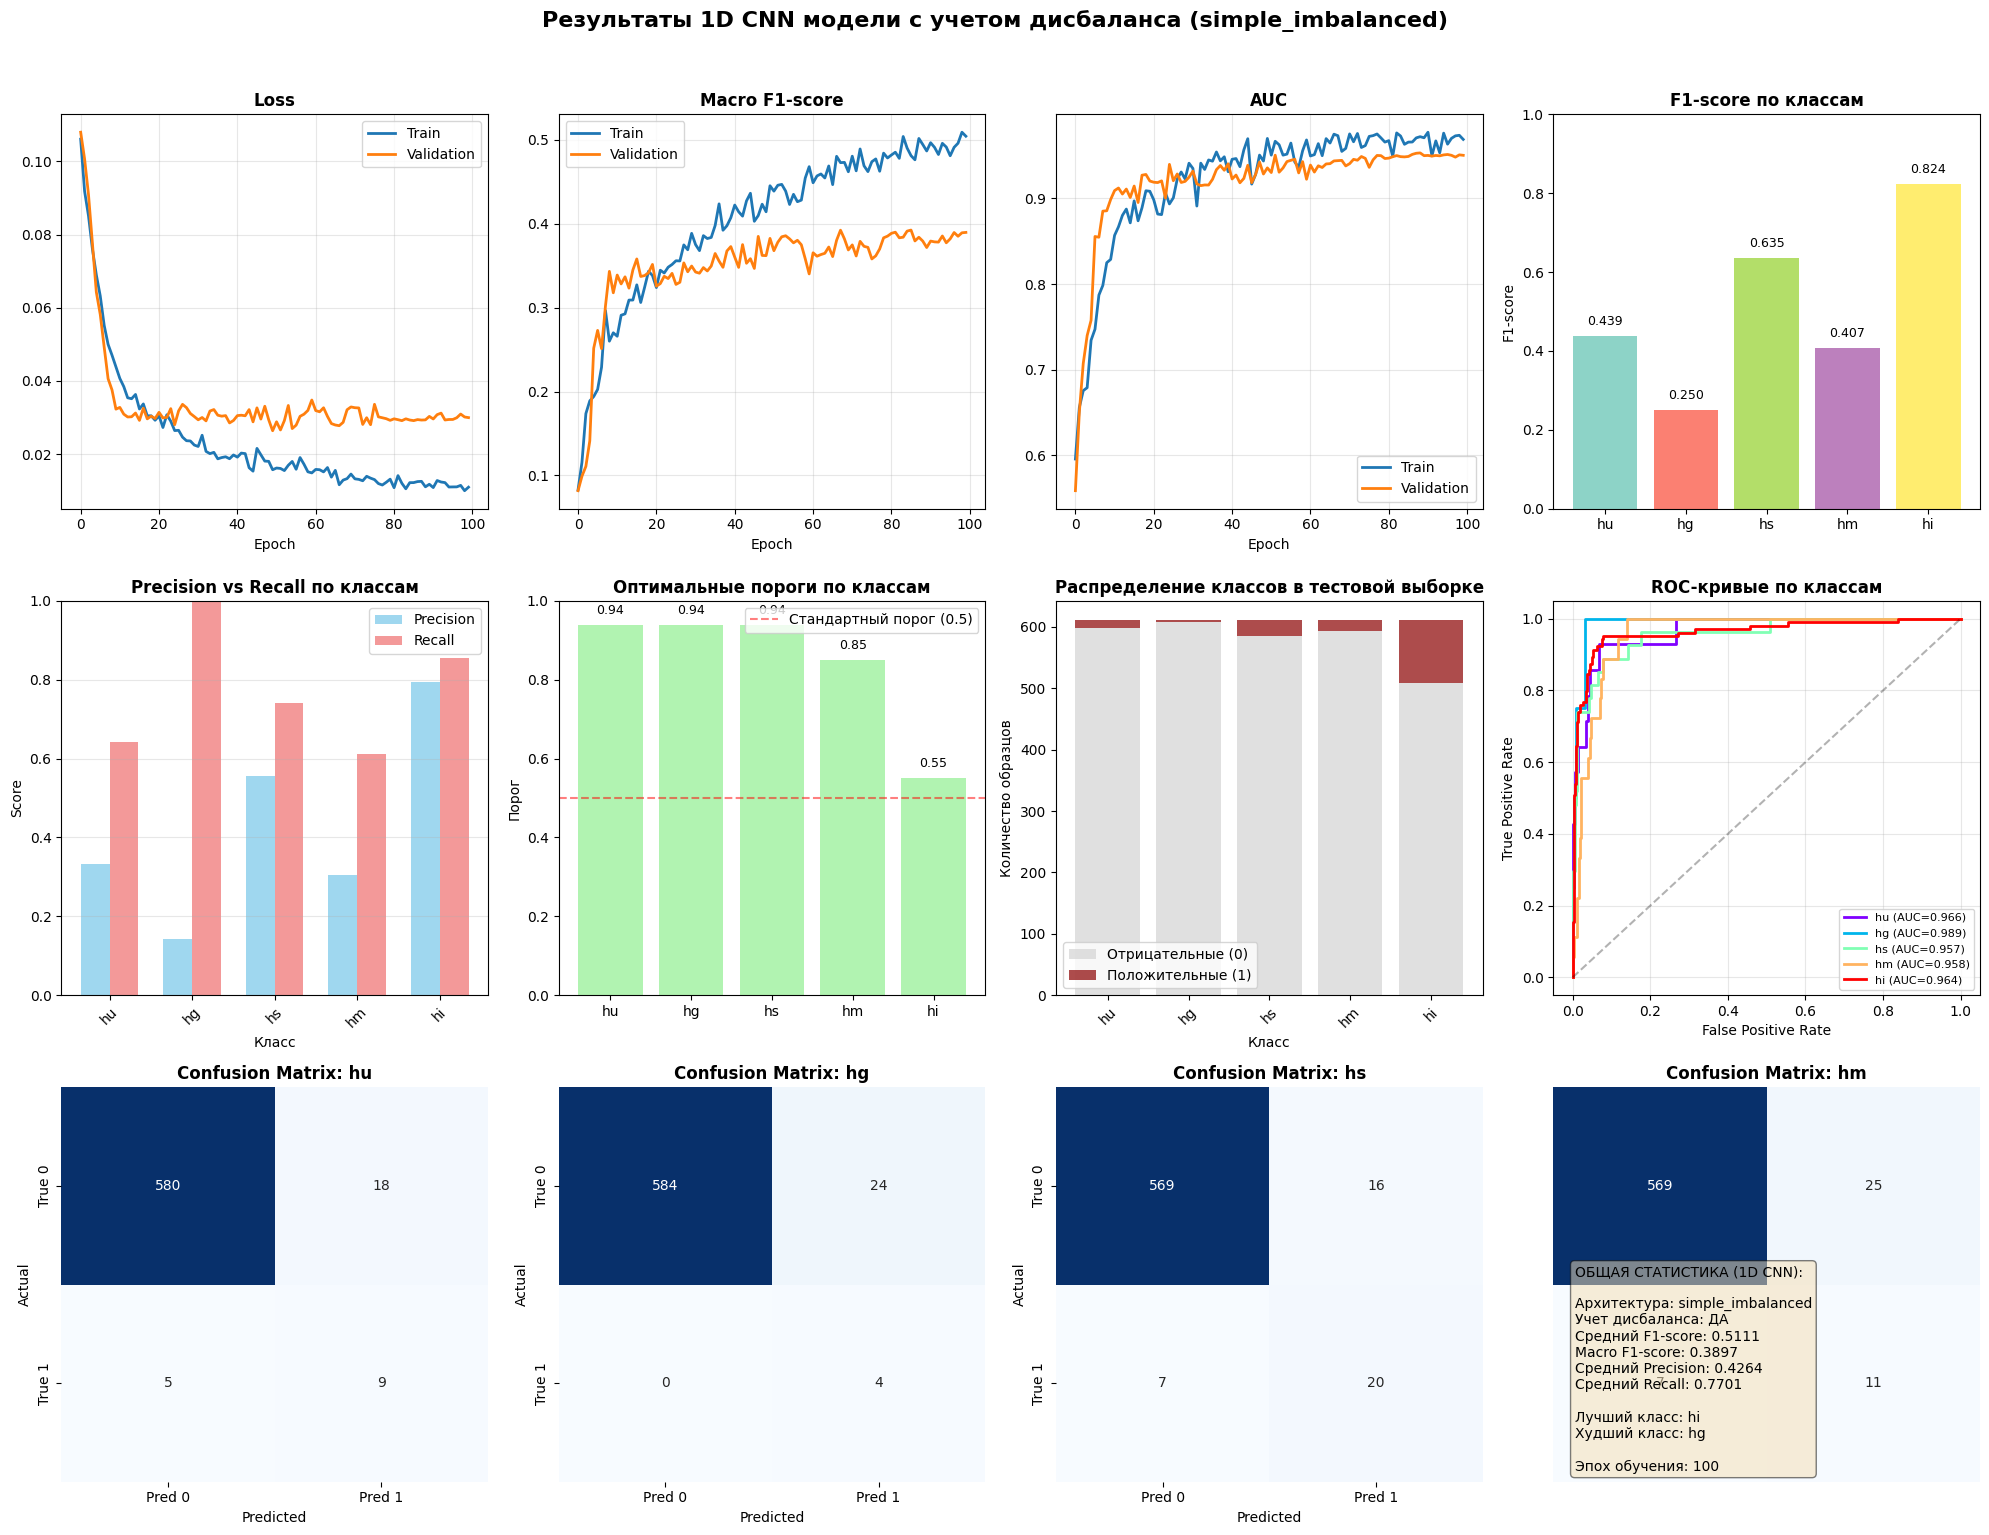

✓ График корреляций сохранен: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/plots/correlation_matrices.png
✓ График распределения классов сохранен: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/plots/class_distribution.png
✓ Графики обучения сохранены: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/plots/training_details.png


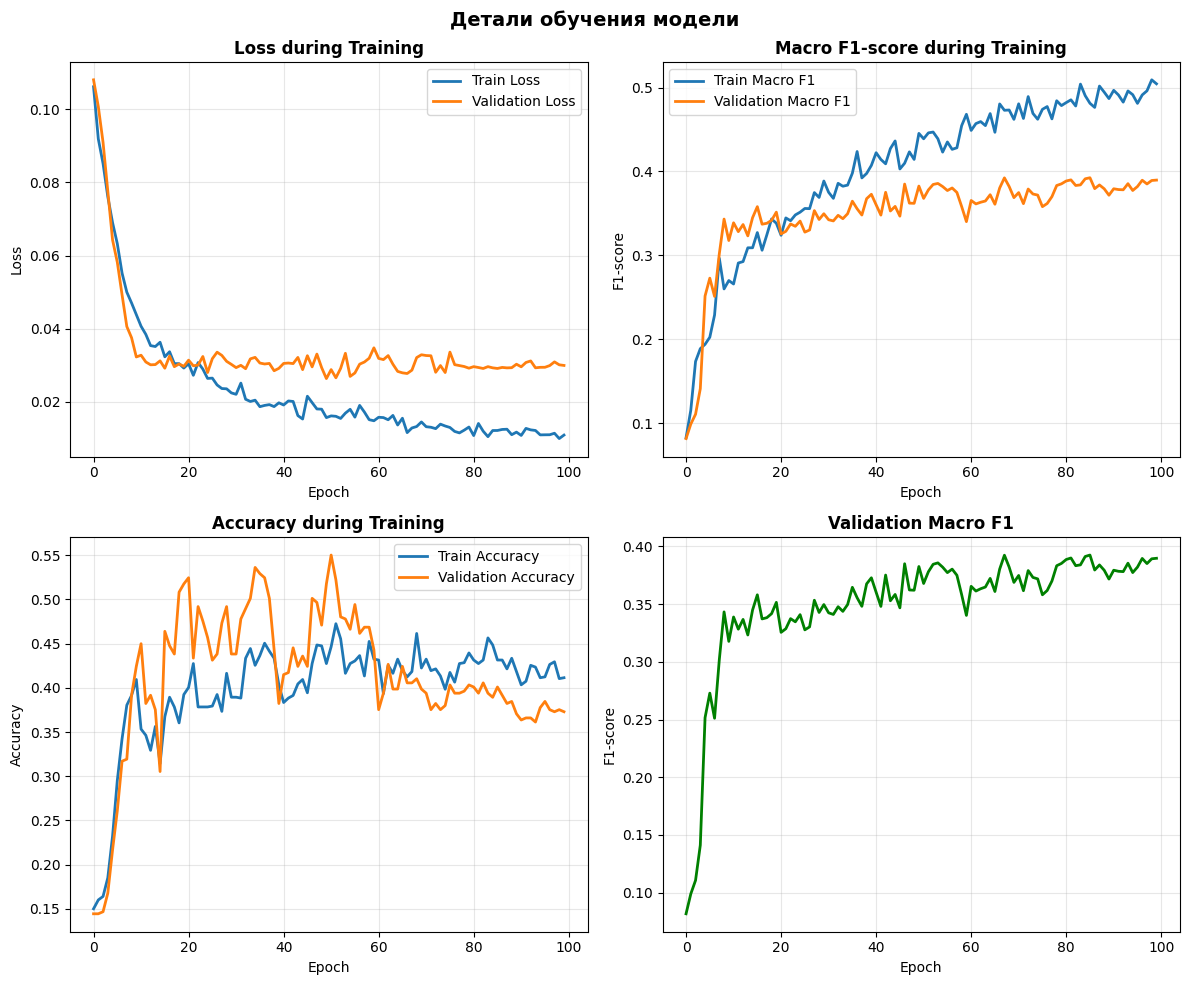


Сохранение результатов в ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced...
✓ Модель сохранена: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/models/best_model.keras
✓ Метрики обучения сохранены в CSV: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/training_metrics.csv
✓ Все результаты сохранены в ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced

ФИНАЛЬНАЯ СВОДКА

Архитектура: simple_imbalanced
Средний F1-score: 0.5111
Лучший val Macro F1: 0.3925 (эпоха 86)
Оптимальные пороги: 0.94, 0.94, 0.94, 0.85, 0.55

СОХРАНЕННЫЕ ФАЙЛЫ:
  Модель: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/models/best_model.keras
  Основной график: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/plots/main_results.png
  Графики обучения: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_imbalanced/plots/training_details.png
  Корреляционные матрицы: ../Debugging_Information/Fin_exp_models/1D_CNN_simple_

In [8]:
# ============================================================================
# ЗАПУСК ЭКСПЕРИМЕНТА 1D CNN
# ============================================================================

# Запуск одного эксперимента
print("НАЧАЛО ЭКСПЕРИМЕНТОВ 1D CNN")
print("="*80)

model, history, results = run_1d_cnn_experiment(
    extractor_type='simple_imbalanced',  # или simple_imbalanced, 'standard', 'by_features', 'bidirectional', 'deeper'
    epochs=100
)

In [9]:
# ============================================================================
# ТОЧНО ТАКОЙ ЖЕ КОД ДЛЯ 1D CNN КАК ДЛЯ 2D CNN
# ============================================================================

# Загружаем данные
data_loader = DataLoader()
X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()

# ============================================================================
# 0. СОЗДАЕМ ПОЛНУЮ МОДЕЛЬ ЧЕРЕЗ Model1DFactory И ВЫВОДИМ ЕЕ
# ============================================================================

# Создаем полную модель 1D CNN
input_shape_1d = (X_train_cnn.shape[1], X_train_cnn.shape[2])  # Для 1D: (timesteps, features)
extractor_type_1d = 'deeper'  # или другая архитектура
num_classes = y_train.shape[1]
class_names = ['hu', 'hg', 'hs', 'hm', 'hi']

# Создаем полную модель через Model1DFactory
print("Создание полной модели 1D CNN...")
model_1d_factory = Model1DFactory()
full_model_1d, feature_extractor_1d = model_1d_factory.create_full_model(
    input_shape_1d,
    num_classes,
    extractor_type=extractor_type_1d,
    num_features=20,  # Любое значение, будет переопределено
    use_class_weights=True,
    y_train=y_train,
    class_names=class_names
)

# Выводим сводку полной модели
print("\n" + "=" * 80)
print("0. СВОДКА ПОЛНОЙ МОДЕЛИ 1D CNN")
print("=" * 80)
full_model_1d.summary()

# ============================================================================
# 1. СОЗДАЕМ FEATURE_EXTRACTOR ЗАНОВО, ЧТОБЫ ИМЕТЬ К НЕМУ ДОСТУП
# ============================================================================

print("\n" + "=" * 80)
print("1. СОЗДАНИЕ FEATURE_EXTRACTOR ДЛЯ 1D CNN")
print("=" * 80)

# Создаем feature_extractor для 1D CNN
extractor_factory_1d = FeatureExtractor1DFactory()

if extractor_type_1d == 'standard':
    feature_extractor = extractor_factory_1d.create_standard(input_shape_1d, num_features=20)
elif extractor_type_1d == 'by_features':
    feature_extractor = extractor_factory_1d.create_by_features(input_shape_1d, num_features=20)
elif extractor_type_1d == 'bidirectional':
    feature_extractor = extractor_factory_1d.create_bidirectional(input_shape_1d, num_features=20)
elif extractor_type_1d == 'deeper':
    feature_extractor = extractor_factory_1d.create_deeper(input_shape_1d, num_features=20)
elif extractor_type_1d == 'simple_imbalanced':
    feature_extractor = extractor_factory_1d.create_simple_imbalanced(input_shape_1d, num_features=20)

# Выводим структуру feature_extractor
print("\n1. Сводка feature_extractor:")
feature_extractor.summary()

# ============================================================================
# 2. СОЗДАЕМ КЛАССИФИКАЦИОННУЮ ГОЛОВКУ С УЧЕТОМ ДИСБАЛАНСА
# ============================================================================

print("\n" + "=" * 80)
print("2. СОЗДАНИЕ КЛАССИФИКАЦИОННОЙ ГОЛОВКИ ДЛЯ 1D CNN")
print("=" * 80)

# Расчет начальных смещений для выходного слоя
print("\nРасчет начальных смещений:")
initial_biases = []
for i in range(num_classes):
    pos_ratio = y_train[:, i].sum() / len(y_train)
    if pos_ratio > 0 and pos_ratio < 1:
        initial_bias = np.log(pos_ratio / (1 - pos_ratio))
    else:
        initial_bias = 0.0
    initial_biases.append(initial_bias)
    
    print(f"  {class_names[i]}: pos_ratio={pos_ratio:.4f}, initial_bias={initial_bias:.4f}")

# Создаем классификационную головку
print("\nСлои классификационной головки:")

# Входной слой для признаков (размерность = num_features из feature_extractor)
num_features = 20  # Должен совпадать с output_dim feature_extractor
features_input = layers.Input(shape=(num_features,), name='features_input')

# Слой 1 (для 1D CNN используется 16 нейронов, как в Model1DFactory)
x = layers.Dense(16, activation='relu', name='classifier_dense1')(features_input)
print(f"1. Dense(16, relu)      -> output shape: {x.shape}")

# Dropout (для 1D CNN rate=0.3, как в Model1DFactory)
x = layers.Dropout(0.3, name='classifier_dropout1')(x)
print(f"2. Dropout(0.3)         -> output shape: {x.shape}")

# Слой 2 (для 1D CNN используется 8 нейронов, как в Model1DFactory)
x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
print(f"3. Dense(8, relu)       -> output shape: {x.shape}")

# Выходной слой с начальным смещением
output = layers.Dense(
    num_classes, 
    activation='sigmoid',
    name='classifier_output',
    kernel_initializer='glorot_normal',
    bias_initializer=tf.keras.initializers.Constant(initial_biases)
)(x)
print(f"4. Dense({num_classes}, sigmoid) -> output shape: {output.shape}")

# Создаем модель классификационной головки
classifier_head = Model(inputs=features_input, outputs=output, name='Classifier_Head_1D')

print("\n" + "-" * 80)
print("Сводка классификационной головки:")
classifier_head.summary()

# ============================================================================
# 3. ПРОВЕРКА РАЗМЕРНОСТЕЙ И СОВМЕСТИМОСТИ
# ============================================================================

print("\n" + "=" * 80)
print("3. ПРОВЕРКА РАЗМЕРНОСТЕЙ")
print("=" * 80)

print(f"Размерность выхода feature_extractor: {feature_extractor.output_shape}")
print(f"Размерность входа classifier_head: {classifier_head.input_shape}")

# Автоматическое получение num_features из feature_extractor
actual_num_features = feature_extractor.output_shape[-1]
print(f"\nАвтоматически определенное количество признаков из feature_extractor: {actual_num_features}")

# Проверяем совпадение
if num_features == actual_num_features:
    print("✓ Количество признаков совпадает с ожидаемым (20)")
else:
    print(f"⚠ Количество признаков не совпадает: ожидалось {num_features}, получено {actual_num_features}")

# ============================================================================
# 4. ФУНКЦИЯ ДЛЯ БЫСТРОГО ВЫВОДА ТРЕХ СВОДОК
# ============================================================================

def print_1d_cnn_summaries(extractor_type='deeper'):
    """
    Функция для быстрого вывода трех сводок 1D CNN
    """
    print("\n" + "═" * 80)
    print(f"ТРИ СВОДКИ 1D CNN МОДЕЛИ ({extractor_type})")
    print("═" * 80)
    
    # Загружаем данные
    data_loader = DataLoader()
    X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()
    
    # Параметры
    input_shape_1d = (X_train_cnn.shape[1], X_train_cnn.shape[2])
    num_classes = y_train.shape[1]
    class_names = ['hu', 'hg', 'hs', 'hm', 'hi']
    
    # 1. Создаем полную модель
    model_factory = Model1DFactory()
    full_model, feature_extractor = model_factory.create_full_model(
        input_shape_1d,
        num_classes,
        extractor_type=extractor_type,
        num_features=20,
        use_class_weights=True,
        y_train=y_train,
        class_names=class_names
    )
    
    print("\n1. ПОЛНАЯ МОДЕЛЬ:")
    full_model.summary()
    
    # 2. Feature extractor (создаем заново)
    extractor_factory = FeatureExtractor1DFactory()
    
    if extractor_type == 'standard':
        feature_extractor = extractor_factory.create_standard(input_shape_1d, num_features=20)
    elif extractor_type == 'by_features':
        feature_extractor = extractor_factory.create_by_features(input_shape_1d, num_features=20)
    elif extractor_type == 'bidirectional':
        feature_extractor = extractor_factory.create_bidirectional(input_shape_1d, num_features=20)
    elif extractor_type == 'deeper':
        feature_extractor = extractor_factory.create_deeper(input_shape_1d, num_features=20)
    elif extractor_type == 'simple_imbalanced':
        feature_extractor = extractor_factory.create_simple_imbalanced(input_shape_1d, num_features=20)
    
    print("\n2. FEATURE_EXTRACTOR:")
    feature_extractor.summary()
    
    # 3. Classifier head
    print("\n3. CLASSIFIER_HEAD:")
    
    # Расчет смещений
    initial_biases = []
    for i in range(num_classes):
        pos_ratio = y_train[:, i].sum() / len(y_train)
        initial_bias = np.log(pos_ratio / (1 - pos_ratio)) if 0 < pos_ratio < 1 else 0.0
        initial_biases.append(initial_bias)
    
    # Создаем classifier_head (точно как в Model1DFactory)
    num_features = 20  # Совпадает с feature_extractor
    inputs = layers.Input(shape=(num_features,), name='features_input')
    x = layers.Dense(16, activation='relu', name='classifier_dense1')(inputs)
    x = layers.Dropout(0.3, name='classifier_dropout1')(x)
    x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
    output = layers.Dense(
        num_classes, 
        activation='sigmoid',
        name='classifier_output',
        bias_initializer=tf.keras.initializers.Constant(initial_biases)
    )(x)
    
    classifier_head = Model(inputs=inputs, outputs=output, name='Classifier_Head_1D')
    classifier_head.summary()

# Запуск функции для разных архитектур
print_1d_cnn_summaries('deeper')
# print_1d_cnn_summaries('simple_imbalanced')
# print_1d_cnn_summaries('standard')

Создание полной модели 1D CNN...

Расчет начальных смещений для выходного слоя:
  hu: pos_ratio=0.0220, initial_bias=-3.7934
  hg: pos_ratio=0.0080, initial_bias=-4.8193
  hs: pos_ratio=0.0440, initial_bias=-3.0775
  hm: pos_ratio=0.0290, initial_bias=-3.5100
  hi: pos_ratio=0.1692, initial_bias=-1.5915

0. СВОДКА ПОЛНОЙ МОДЕЛИ 1D CNN


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "1D_CNN_Deeper_Imbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1D_CNN_Deeper_Extractor         │ (None, 20)             │       108,564 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,081 (426.10 KB)

 Trainable params: 108,185 (422.60 KB)

 Non-trainable params: 896 (3.50 KB)


1. СОЗДАНИЕ FEATURE_EXTRACTOR ДЛЯ 1D CNN

1. Сводка feature_extractor:


Model: "1D_CNN_Deeper_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1b (Conv1D)              │ (None, 25, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1b (BatchNormalization)       │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2b (Conv1D)              │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2b (BatchNormalization)       │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3b (Conv1D)              │ (None, 6, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3b (BatchNormalization)       │ (None, 6, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,564 (424.08 KB)

 Trainable params: 107,668 (420.58 KB)

 Non-trainable params: 896 (3.50 KB)


2. СОЗДАНИЕ КЛАССИФИКАЦИОННОЙ ГОЛОВКИ ДЛЯ 1D CNN

Расчет начальных смещений:
  hu: pos_ratio=0.0220, initial_bias=-3.7934
  hg: pos_ratio=0.0080, initial_bias=-4.8193
  hs: pos_ratio=0.0440, initial_bias=-3.0775
  hm: pos_ratio=0.0290, initial_bias=-3.5100
  hi: pos_ratio=0.1692, initial_bias=-1.5915

Слои классификационной головки:
1. Dense(16, relu)      -> output shape: (None, 16)
2. Dropout(0.3)         -> output shape: (None, 16)
3. Dense(8, relu)       -> output shape: (None, 8)
4. Dense(5, sigmoid) -> output shape: (None, 5)

--------------------------------------------------------------------------------
Сводка классификационной головки:


Model: "Classifier_Head_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features_input (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517 (2.02 KB)

 Trainable params: 517 (2.02 KB)

 Non-trainable params: 0 (0.00 B)


3. ПРОВЕРКА РАЗМЕРНОСТЕЙ
Размерность выхода feature_extractor: (None, 20)
Размерность входа classifier_head: (None, 20)

Автоматически определенное количество признаков из feature_extractor: 20
✓ Количество признаков совпадает с ожидаемым (20)

════════════════════════════════════════════════════════════════════════════════
ТРИ СВОДКИ 1D CNN МОДЕЛИ (deeper)
════════════════════════════════════════════════════════════════════════════════

Расчет начальных смещений для выходного слоя:
  hu: pos_ratio=0.0220, initial_bias=-3.7934
  hg: pos_ratio=0.0080, initial_bias=-4.8193
  hs: pos_ratio=0.0440, initial_bias=-3.0775
  hm: pos_ratio=0.0290, initial_bias=-3.5100
  hi: pos_ratio=0.1692, initial_bias=-1.5915

1. ПОЛНАЯ МОДЕЛЬ:


Model: "1D_CNN_Deeper_Imbalanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1D_CNN_Deeper_Extractor         │ (None, 20)             │       108,564 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,081 (426.10 KB)

 Trainable params: 108,185 (422.60 KB)

 Non-trainable params: 896 (3.50 KB)


2. FEATURE_EXTRACTOR:


Model: "1D_CNN_Deeper_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1b (Conv1D)              │ (None, 25, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1b (BatchNormalization)       │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2b (Conv1D)              │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2b (BatchNormalization)       │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3b (Conv1D)              │ (None, 6, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3b (BatchNormalization)       │ (None, 6, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,564 (424.08 KB)

 Trainable params: 107,668 (420.58 KB)

 Non-trainable params: 896 (3.50 KB)


3. CLASSIFIER_HEAD:


Model: "Classifier_Head_1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features_input (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517 (2.02 KB)

 Trainable params: 517 (2.02 KB)

 Non-trainable params: 0 (0.00 B)